### Fitting DataSets to Shallow and Deep Neural Net

#### Easy (Titanic)

Preprocessing

In [156]:
import pandas as pd
import numpy as np
import re
import keras
from keras import models
from keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
# https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8

In [3]:
# Load data
titanic = pd.read_csv(r"C:\Users\Axel\Documents\Nova_IMS\2_Semester\Deep Learning\Project\data_files\data_files\Easy\titanic.csv")

In [4]:
# Drop ticket, home.dest, boat, body
titanic = titanic.drop(['ticket'], axis=1)
titanic = titanic.drop(['home.dest'], axis=1)
titanic = titanic.drop(['boat'], axis=1)
titanic = titanic.drop(['body'], axis=1)

In [5]:
# Deal with cabin missing values
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

titanic['cabin'] = titanic['cabin'].fillna("U0")
titanic['deck'] = titanic['cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
titanic['deck'] = titanic['deck'].map(deck)
titanic['deck'] = titanic['deck'].fillna(0)
titanic['deck'] = titanic['deck'].astype(int)
# we can now drop the cabin feature
titanic = titanic.drop(['cabin'], axis=1)

In [6]:
# Deal with Age missing values
mean = titanic["age"].mean()
std = titanic["age"].std()
is_null = titanic["age"].isnull().sum()
# compute random numbers between the mean, std and is_null
rand_age = np.random.randint(mean - std, mean + std, size = is_null)
# fill NaN values in Age column with random values generated
age_slice = titanic["age"].copy()
age_slice[np.isnan(age_slice)] = rand_age
titanic["age"] = age_slice
titanic["age"] = titanic["age"].astype(int)

In [7]:
# Deal with Embarked missing values
common_value = 'S'
titanic['embarked'] = titanic['embarked'].fillna(common_value)

In [8]:
# Converting Fares
titanic['fare'] = titanic['fare'].fillna(0)
titanic['fare'] = titanic['fare'].astype(int)

In [9]:
# Converting Names
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

# extract titles
titanic['title'] = titanic.name.str.extract(' ([A-Za-z]+)\.', expand=False)
# replace titles with a more common title or as Rare
titanic['title'] = titanic['title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
titanic['title'] = titanic['title'].replace('Mlle', 'Miss')
titanic['title'] = titanic['title'].replace('Ms', 'Miss')
titanic['title'] = titanic['title'].replace('Mme', 'Mrs')
# convert titles into numbers
titanic['title'] = titanic['title'].map(titles)
# filling NaN with 0, to get safe
titanic['title'] = titanic['title'].fillna(0)
titanic = titanic.drop(['name'], axis=1)

In [10]:
# Converting Sex
genders = {"male": 0, "female": 1}
titanic['sex'] = titanic['sex'].map(genders)

In [11]:
# Converting Embarked
ports = {"S": 0, "C": 1, "Q": 2}
titanic['embarked'] = titanic['embarked'].map(ports)

In [12]:
# Rearrange columns
titanic = titanic[['pclass', "sex","age","sibsp","parch","fare", "embarked", "deck", "title", "survived"]]

In [13]:
# Encoding

In [14]:
onehotencoder = OneHotEncoder(categorical_features = [0, 3, 4, 7, 8])
titanic = onehotencoder.fit_transform(titanic).toarray()

C:\Users\Axel\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\Axel\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:385: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [15]:
titanic = pd.DataFrame(titanic)

In [16]:
titanic.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,29.0,211.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,151.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,2.0,151.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,30.0,151.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,25.0,151.0,0.0,0.0


Split to train and test set

In [17]:
# Create train, test set
y = titanic[36]
X = titanic.drop(36, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
# get validation set
x_val = X_train[:100]
partial_X_train = X_train[100:]
y_val = y_train[:100]
partial_y_train = y_train[100:]

Shallow Neural Net

In [19]:
def keras_shallow(input_dim=39, n_layers=3, n_neurons=6, r_dropout=0.5, optimizer="rmsprop", loss="binary_crossentropy", init="uniform", metrics=["accuracy"], random_state=42):
    """
    shallow neural net, define the amount of layers either having 1 or 2 hidden layers., which optimizer you want to use and which loss function you want to apply.
    """ 
    np.random.seed(random_state)
    

    from keras import backend as K
    K.clear_session()


    model = models.Sequential()
    model.add(layers.Dense(n_neurons, activation="relu", input_dim=input_dim))
    model.add(layers.Dropout(r_dropout))
    for num in range(n_layers-2):
        model.add(layers.Dense(n_neurons, activation="relu"))
        model.add(layers.Dropout(r_dropout))
    model.add(layers.Dense(1, activation="sigmoid", init=init))
    model.compile(optimizer, loss, metrics=metrics)
    
    return model

In [20]:
shallow_nn = keras_shallow(input_dim=len(X_train.columns))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\Axel\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`


In [21]:
history_shallow = shallow_nn.fit(partial_X_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 816 samples, validate on 100 samples
Epoch 1/20
816/816 [==============================] - 0s 429us/step - loss: 0.6830 - acc: 0.6005 - val_loss: 0.6813 - val_acc: 0.6800
Epoch 2/20
816/816 [==============================] - 0s 13us/step - loss: 0.6822 - acc: 0.5931 - val_loss: 0.6795 - val_acc: 0.6800
Epoch 3/20
816/816 [==============================] - 0s 17us/step - loss: 0.6712 - acc: 0.6409 - val_loss: 0.6746 - val_acc: 0.6800
Epoch 4/20
816/816 [==============================] - 0s 12us/step - loss: 0.6757 - acc: 0.6115 - val_loss: 0.6721 - val_acc: 0.6700
Epoch 5/20
816/816 [==============================] - 0s 9us/step - loss: 0.6713 - acc: 0.6115 - val_loss: 0.6690 - val_acc: 0.6700
Epoch 6/20
816/816 [==============================] - 0s 10us/step - loss: 0.6708 - acc: 0.6201 - val_loss: 0.6686 - val_acc: 0.6700
Epoch 7/20
816/816 [==============================] - 0s 16us/step - loss: 0.6686 - acc: 0.6348 - val_loss: 

In [22]:
history_dict = history_shallow.history

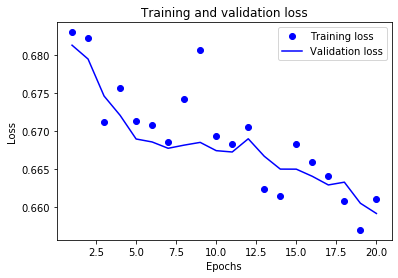

In [23]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

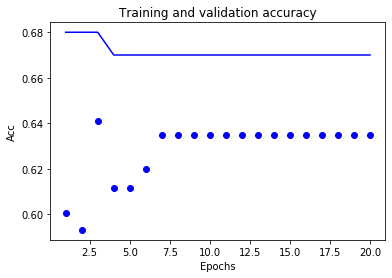

In [24]:
plt.clf()
acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.show()

In [25]:
shallow_nn.predict(X_test)

array([[0.429147  ],
       [0.46987537],
       [0.42030573],
       [0.4360147 ],
       [0.44666192],
       [0.43911797],
       [0.44696036],
       [0.4481216 ],
       [0.43417728],
       [0.48468736],
       [0.4718234 ],
       [0.4881969 ],
       [0.47520915],
       [0.46131203],
       [0.43269652],
       [0.45430526],
       [0.43254834],
       [0.44564828],
       [0.4865041 ],
       [0.46840948],
       [0.45591885],
       [0.4276629 ],
       [0.45412666],
       [0.46110028],
       [0.45397702],
       [0.48533726],
       [0.42498377],
       [0.4445909 ],
       [0.45251164],
       [0.48542964],
       [0.4500025 ],
       [0.48664367],
       [0.482352  ],
       [0.48040724],
       [0.48850143],
       [0.4446935 ],
       [0.48921725],
       [0.43919018],
       [0.48921725],
       [0.45318118],
       [0.43984377],
       [0.45927343],
       [0.42209756],
       [0.45131502],
       [0.46622953],
       [0.44875   ],
       [0.43755674],
       [0.461

Deep Neural Network

In [26]:
def keras_deep(input_dim=39, n_layers=9, n_neurons=12, r_dropout=0.5, optimizer="rmsprop", loss="binary_crossentropy", init="uniform", metrics=["accuracy"], random_state=42):
    """
    Keras Neural Network, define the amount of layers you want, which optimizer you want to use and which loss function you want to apply.
    """ 
    np.random.seed(random_state)
    

    from keras import backend as K
    K.clear_session()


    model = models.Sequential()
    model.add(layers.Dense(n_neurons, activation="relu", input_dim=input_dim))
    model.add(layers.Dropout(r_dropout))
    for num in range(n_layers-2):
        model.add(layers.Dense(n_neurons, activation="relu"))
        model.add(layers.Dropout(r_dropout))
    model.add(layers.Dense(1, activation="sigmoid", init=init))
    model.compile(optimizer, loss, metrics=metrics)
    
    return model

In [27]:
deep_nn = keras_deep(input_dim=len(X_train.columns))

C:\Users\Axel\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`


In [28]:
history_deep = deep_nn.fit(partial_X_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 816 samples, validate on 100 samples
Epoch 1/20
816/816 [==============================] - 1s 1ms/step - loss: 0.7269 - acc: 0.6066 - val_loss: 0.6919 - val_acc: 0.6700
Epoch 2/20
816/816 [==============================] - 0s 18us/step - loss: 0.6986 - acc: 0.6140 - val_loss: 0.6912 - val_acc: 0.6700
Epoch 3/20
816/816 [==============================] - 0s 17us/step - loss: 0.7101 - acc: 0.6287 - val_loss: 0.6908 - val_acc: 0.6700
Epoch 4/20
816/816 [==============================] - 0s 20us/step - loss: 0.6937 - acc: 0.6103 - val_loss: 0.6903 - val_acc: 0.6700
Epoch 5/20
816/816 [==============================] - 0s 21us/step - loss: 0.6956 - acc: 0.6201 - val_loss: 0.6899 - val_acc: 0.6700
Epoch 6/20
816/816 [==============================] - 0s 22us/step - loss: 0.7000 - acc: 0.6127 - val_loss: 0.6895 - val_acc: 0.6700
Epoch 7/20
816/816 [==============================] - 0s 17us/step - loss: 0.6918 - acc: 0.6287 - val_loss: 0.6891 - val_acc: 0.6700
Epoch 8/20
816/816 [====

In [29]:
history_dict = history_deep.history

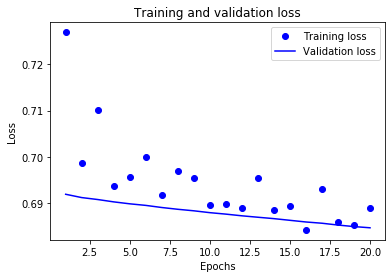

In [30]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

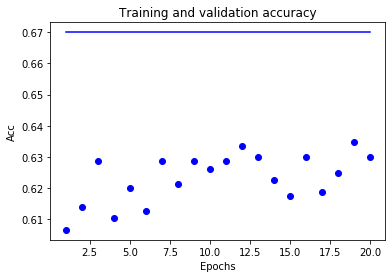

In [31]:
plt.clf()
acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.show()

In [32]:
deep_nn.predict(X_test)

array([[0.4871001 ],
       [0.48680896],
       [0.48710138],
       [0.48707098],
       [0.48701772],
       [0.48708865],
       [0.4869901 ],
       [0.48706165],
       [0.48710018],
       [0.48639125],
       [0.4863857 ],
       [0.48639125],
       [0.4868427 ],
       [0.48692352],
       [0.48708528],
       [0.48696545],
       [0.4871    ],
       [0.48699695],
       [0.48632693],
       [0.486877  ],
       [0.4869496 ],
       [0.48706967],
       [0.4869546 ],
       [0.48696285],
       [0.48696297],
       [0.48638266],
       [0.4871184 ],
       [0.4870294 ],
       [0.48697767],
       [0.4863172 ],
       [0.4870636 ],
       [0.48636812],
       [0.48660424],
       [0.48639125],
       [0.48633498],
       [0.48702836],
       [0.48634312],
       [0.48712134],
       [0.48635966],
       [0.4869911 ],
       [0.48705515],
       [0.48694846],
       [0.48711154],
       [0.4869973 ],
       [0.48691905],
       [0.48697928],
       [0.48706976],
       [0.486

#### Santander (Big)

Preprocessing

In [33]:
# Load data
santander = pd.read_csv(r"C:\Users\Axel\Documents\Nova_IMS\2_Semester\Deep Learning\Project\data_files\data_files\Big\santander.csv")

In [34]:
santander = santander.drop(["ID_code"], axis=1)

Split train and test data

In [35]:
# Get train and test set
y = santander.target
X = santander.drop(["target"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
# get validation set
x_val = X_train[:10000]
partial_X_train = X_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Shallow Neural Net

In [37]:
shallow_nn = keras_shallow(input_dim=len(X_train.columns))

C:\Users\Axel\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`


In [38]:
history_shallow = shallow_nn.fit(partial_X_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 130000 samples, validate on 10000 samples
Epoch 1/20
130000/130000 [==============================] - 3s 20us/step - loss: 0.4377 - acc: 0.8983 - val_loss: 0.3719 - val_acc: 0.9033
Epoch 2/20
130000/130000 [==============================] - 2s 18us/step - loss: 0.3823 - acc: 0.9001 - val_loss: 0.3334 - val_acc: 0.9033
Epoch 3/20
130000/130000 [==============================] - 2s 18us/step - loss: 0.3417 - acc: 0.9001 - val_loss: 0.2861 - val_acc: 0.9033
Epoch 4/20
130000/130000 [==============================] - 2s 18us/step - loss: 0.3185 - acc: 0.9001 - val_loss: 0.2881 - val_acc: 0.9033
Epoch 5/20
130000/130000 [==============================] - 2s 18us/step - loss: 0.3064 - acc: 0.9001 - val_loss: 0.2768 - val_acc: 0.9033
Epoch 6/20
130000/130000 [==============================] - 2s 18us/step - loss: 0.3020 - acc: 0.9001 - val_loss: 0.2762 - val_acc: 0.9033
Epoch 7/20
130000/130000 [==============================] - 2s 19us/step - loss: 0.2986 - acc: 0.9001 - val_loss: 0

In [39]:
history_dict = history_shallow.history

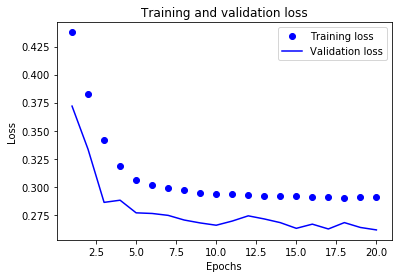

In [40]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

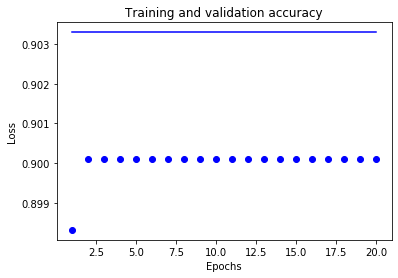

In [41]:
plt.clf()
acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [42]:
shallow_nn.predict(X_test)

array([[0.00323552],
       [0.01135421],
       [0.01466438],
       ...,
       [0.1744521 ],
       [0.00266078],
       [0.06802177]], dtype=float32)

Deep Neural Network

In [43]:
deep_nn = keras_deep(input_dim=len(X_train.columns))

C:\Users\Axel\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`


In [44]:
history_deep = deep_nn.fit(partial_X_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 130000 samples, validate on 10000 samples
Epoch 1/20
130000/130000 [==============================] - 4s 30us/step - loss: 0.5108 - acc: 0.8982 - val_loss: 0.5003 - val_acc: 0.9033
Epoch 2/20
130000/130000 [==============================] - 3s 24us/step - loss: 0.3769 - acc: 0.9001 - val_loss: 0.3218 - val_acc: 0.9033
Epoch 3/20
130000/130000 [==============================] - 3s 25us/step - loss: 0.3417 - acc: 0.9001 - val_loss: 0.3192 - val_acc: 0.9033
Epoch 4/20
130000/130000 [==============================] - 3s 25us/step - loss: 0.3351 - acc: 0.9001 - val_loss: 0.3184 - val_acc: 0.9033
Epoch 5/20
130000/130000 [==============================] - 3s 25us/step - loss: 0.3314 - acc: 0.9001 - val_loss: 0.3202 - val_acc: 0.9033
Epoch 6/20
130000/130000 [==============================] - 3s 25us/step - loss: 0.3288 - acc: 0.9001 - val_loss: 0.3202 - val_acc: 0.9033
Epoch 7/20
130000/130000 [==============================] - 3s 25us/step - loss: 0.3257 - acc: 0.9001 - val_loss: 0

In [45]:
history_dict = history_deep.history

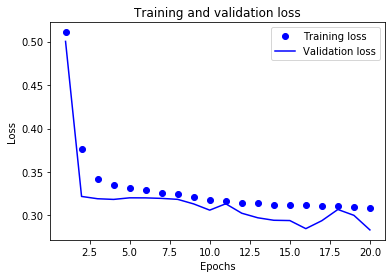

In [46]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

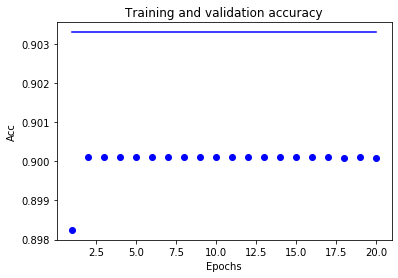

In [47]:
plt.clf()
acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.show()

In [48]:
deep_nn.predict(X_test)

array([[0.01027769],
       [0.01439443],
       [0.04632923],
       ...,
       [0.13984898],
       [0.00531283],
       [0.06007391]], dtype=float32)

#### Weather Australia (Time Series)

Preprocessing

In [131]:
weather = pd.read_csv(r"C:\Users\Axel\Documents\Nova_IMS\2_Semester\Deep Learning\Project\data_files\data_files\TimeSeries\weatherAUS.csv")

In [132]:
weather.head(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No
5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,0.0,No
6,2008-12-07,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,...,19.0,1009.6,1008.2,1.0,NaN,18.1,24.6,No,0.0,No
7,2008-12-08,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,0.0,No
8,2008-12-09,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,...,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,No,1.4,Yes
9,2008-12-10,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,...,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,Yes,0.0,No


In [133]:
weather.shape

(142193, 24)

In [134]:
weather.isna().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

In [135]:
weather = weather.drop(["Evaporation","Sunshine","Cloud9am","Cloud3pm"], axis=1)

In [136]:
weather.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,0.2,No


In [137]:
weather['RainTomorrow'] = weather['RainTomorrow'].map({'Yes': 1, 'No': 0})
weather['RainToday'] = weather['RainToday'].map({'Yes': 1, 'No': 0})

In [138]:
weather["WindGustDir"].value_counts()

W      9780
SE     9309
E      9071
N      9033
SSE    8993
S      8949
WSW    8901
SW     8797
SSW    8610
WNW    8066
NW     8003
ENE    7992
ESE    7305
NE     7060
NNW    6561
NNE    6433
Name: WindGustDir, dtype: int64

In [139]:
weather["Temp3pm"] = weather["Temp3pm"].fillna(weather["Temp3pm"].mean())
weather["Pressure3pm"] = weather["Pressure3pm"].fillna(weather["Pressure3pm"].mean())
weather["Temp9am"] = weather["Temp9am"].fillna(weather["Temp9am"].mean())
weather["Pressure9am"] = weather["Pressure3pm"].fillna(weather["Pressure3pm"].mean())
weather["Humidity9am"] = weather["Humidity9am"].fillna(weather["Humidity9am"].mean())
weather["Humidity3pm"] = weather["Humidity3pm"].fillna(weather["Humidity3pm"].mean())
weather["MinTemp"] = weather["MinTemp"].fillna(weather["MinTemp"].mean())
weather["MaxTemp"] = weather["MaxTemp"].fillna(weather["MaxTemp"].mean())
weather["WindGustSpeed"] = weather["WindGustSpeed"].fillna(weather["WindGustSpeed"].mean())
weather["WindSpeed9am"] = weather["WindSpeed9am"].fillna(weather["WindSpeed9am"].mean())
weather["WindSpeed3pm"] = weather["WindSpeed3pm"].fillna(weather["WindSpeed3pm"].mean())

In [140]:
weather.isna().sum()

Date                 0
Location             0
MinTemp              0
MaxTemp              0
Rainfall          1406
WindGustDir       9330
WindGustSpeed        0
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure9am          0
Pressure3pm          0
Temp9am              0
Temp3pm              0
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

In [141]:
weather = weather.drop(["WindGustDir","WindDir9am"], axis=1)

In [142]:
weather = weather[pd.notnull(weather['RainToday'])]
weather = weather[pd.notnull(weather['Rainfall'])]
weather = weather[pd.notnull(weather['WindDir3pm'])]

In [143]:
weather.shape

(137117, 18)

In [144]:
weather.isna().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustSpeed    0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
RainToday        0
RISK_MM          0
RainTomorrow     0
dtype: int64

In [145]:
weather.head(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,44.0,WNW,20.0,24.0,71.0,22.0,1007.1,1007.1,16.9,21.8,0.0,0.0,0
1,2008-12-02,Albury,7.4,25.1,0.0,44.0,WSW,4.0,22.0,44.0,25.0,1007.8,1007.8,17.2,24.3,0.0,0.0,0
2,2008-12-03,Albury,12.9,25.7,0.0,46.0,WSW,19.0,26.0,38.0,30.0,1008.7,1008.7,21.0,23.2,0.0,0.0,0
3,2008-12-04,Albury,9.2,28.0,0.0,24.0,E,11.0,9.0,45.0,16.0,1012.8,1012.8,18.1,26.5,0.0,1.0,0
4,2008-12-05,Albury,17.5,32.3,1.0,41.0,NW,7.0,20.0,82.0,33.0,1006.0,1006.0,17.8,29.7,0.0,0.2,0
5,2008-12-06,Albury,14.6,29.7,0.2,56.0,W,19.0,24.0,55.0,23.0,1005.4,1005.4,20.6,28.9,0.0,0.0,0
6,2008-12-07,Albury,14.3,25.0,0.0,50.0,W,20.0,24.0,49.0,19.0,1008.2,1008.2,18.1,24.6,0.0,0.0,0
7,2008-12-08,Albury,7.7,26.7,0.0,35.0,W,6.0,17.0,48.0,19.0,1010.1,1010.1,16.3,25.5,0.0,0.0,0
8,2008-12-09,Albury,9.7,31.9,0.0,80.0,NW,7.0,28.0,42.0,9.0,1003.6,1003.6,18.3,30.2,0.0,1.4,1
9,2008-12-10,Albury,13.1,30.1,1.4,28.0,SSE,15.0,11.0,58.0,27.0,1005.7,1005.7,20.1,28.2,1.0,0.0,0


In [146]:
weather["Date"] = pd.to_datetime(weather["Date"])

In [147]:
start = min(weather["Date"])
date_features = [(i - start) for i in weather["Date"]]
date_features = [i.days for i in date_features]

In [148]:
#https://stackoverflow.com/questions/42044003/how-to-use-date-and-time-values-as-features-to-predict-a-value-using-a-neural-ne
weather["Date"] = date_features

In [149]:
weather = weather.drop(["Location"], axis=1)

In [152]:
weather['WindDir3pm'] = weather['WindDir3pm'].map({'SE': 1, 'W': 2, "S":3, "WSW":4,"SW":5,"SSE":6,"N":7,"WNW":8,"NW":9,
                                                      "ESE":10,"E":11,"NE":12,"SSW":13,"NNW":14,"ENE":15,"NNE":16})

In [158]:
# Rearrange columns
cols = weather.columns.tolist()
cols = cols[-1:] + cols[:-1]
weather = weather[cols]

In [160]:
onehotencoder = OneHotEncoder(categorical_features = ["WindDir3pm"])
weather = onehotencoder.fit_transform(weather).toarray()
weather = pd.DataFrame(weather)

C:\Users\Axel\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\Axel\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:385: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


IndexError: arrays used as indices must be of integer (or boolean) type

Split into Train and Test Set

In [ ]:
# Get train and test set
y = santander.RainTomorrow
X = santander.drop(["RainTomorrow"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# get validation set
x_val = X_train[:10000]
partial_X_train = X_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Shallow Neural Network

In [ ]:
shallow_nn = keras_shallow(input_dim=len(X_train.columns))

In [ ]:
history_shallow = shallow_nn.fit(partial_X_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

In [ ]:
history_dict = history_shallow.history

In [ ]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
plt.clf()
acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
shallow_nn.predict(X_test)

Deep Neural Network

In [ ]:
deep_nn = keras_deep(input_dim=len(X_train.columns))

In [ ]:
history_deep = deep_nn.fit(partial_X_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

In [ ]:
history_dict = history_deep.history

In [ ]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
plt.clf()
acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.show()

In [ ]:
deep_nn.predict(X_test)

#### Cactus (Image)

Preprocessing

In [106]:
train_dir = r'C:\Users\Axel\Documents\Nova_IMS\2_Semester\Deep Learning\Project\data_files\data_files\Cactus_Image\training_set'
test_dir = r"C:\Users\Axel\Documents\Nova_IMS\2_Semester\Deep Learning\Project\data_files\data_files\Cactus_Image\testing_set"

In [107]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [108]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(64, 64),
        batch_size=20,
        class_mode="binary")

Found 17500 images belonging to 2 classes.


In [109]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(64, 64),
        batch_size=20,
        class_mode="binary")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\Axel\\Documents\\Nova_IMS\\2_Semester\\Deep Learning\\Project\\data_files\\data_files\\Cactus_Image\\testing_set'

In [110]:
train_generator[0][0][5].shape

(64, 64, 3)

In [111]:
image1 = train_generator[0][0][0].flatten()

In [112]:
image1

array([0.5921569 , 0.48235297, 0.57254905, ..., 0.6627451 , 0.5764706 ,
       0.6666667 ], dtype=float32)

In [113]:
images = pd.DataFrame(image1)

In [114]:
images = images.transpose()

In [115]:
images

,0,1,2,3,4,5,6,7,8,9,...,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287
0,0.592157,0.482353,0.572549,0.592157,0.482353,0.572549,0.647059,0.537255,0.627451,0.647059,...,0.635294,0.631373,0.545098,0.635294,0.662745,0.576471,0.666667,0.662745,0.576471,0.666667


In [116]:
for i in train_generator:
    n=0
    while n <= 19:
        a = i[0][n].flatten()
        print(a)
        n = n+1
        b= pd.DataFrame(a)
        b=b.transpose()
        images=images.append(b)

[0.5686275  0.45882356 0.54901963 ... 0.5921569  0.4784314  0.5568628 ]
[0.3803922  0.38431376 0.3647059  ... 0.43921572 0.40000004 0.39607847]
[0.63529414 0.5254902  0.6156863  ... 0.5647059  0.46274513 0.5137255 ]
[0.8117648 0.7176471 0.7725491 ... 0.8078432 0.7254902 0.8000001]
[0.6156863  0.5529412  0.6039216  ... 0.41176474 0.3137255  0.39607847]
[0.34117648 0.29411766 0.29411766 ... 0.48235297 0.40000004 0.427451  ]
[0.6117647  0.5529412  0.5411765  ... 0.60784316 0.53333336 0.5411765 ]
[1.         0.97647065 1.         ... 0.5254902  0.39607847 0.4784314 ]
[0.60784316 0.58431375 0.5921569  ... 0.62352943 0.5176471  0.5764706 ]
[0.6392157  0.5764706  0.5764706  ... 0.60784316 0.54901963 0.52156866]
[0.427451   0.39607847 0.38431376 ... 0.56078434 0.5058824  0.49411768]
[0.43137258 0.44705886 0.35686275 ... 0.57254905 0.57254905 0.5803922 ]
[0.45098042 0.46274513 0.427451   ... 0.5137255  0.454902   0.48235297]
[0.44705886 0.40784317 0.41176474 ... 0.30980393 0.2784314  0.32156864

[0.42352945 0.3529412  0.34509805 ... 0.42352945 0.37254903 0.34117648]
[0.3372549  0.29411766 0.3254902  ... 0.45098042 0.4156863  0.39607847]
[0.4901961  0.40000004 0.4784314  ... 0.45882356 0.3921569  0.4666667 ]
[0.6745098 0.627451  0.6431373 ... 0.5647059 0.5176471 0.5254902]
[0.78823537 0.69803923 0.7686275  ... 0.6        0.54509807 0.6039216 ]
[0.6117647  0.5568628  0.5137255  ... 0.58431375 0.5176471  0.4901961 ]
[0.30588236 0.3529412  0.3137255  ... 0.38823533 0.3254902  0.37647063]
[0.5686275  0.5058824  0.50980395 ... 0.69411767 0.6156863  0.61960787]
[0.27058825 0.24705884 0.25490198 ... 0.43921572 0.44705886 0.39607847]
[0.43137258 0.36078432 0.36078432 ... 0.46274513 0.36078432 0.45882356]
[0.4431373  0.38823533 0.44705886 ... 0.49411768 0.41960788 0.49411768]
[0.6        0.5568628  0.54901963 ... 0.5686275  0.50980395 0.48235297]
[0.5686275  0.48627454 0.54509807 ... 0.8078432  0.7411765  0.8117648 ]
[0.6313726  0.57254905 0.5921569  ... 0.73333335 0.63529414 0.70980394

[0.45882356 0.4666667  0.42352945 ... 0.34117648 0.36078432 0.3372549 ]
[0.6509804  0.5411765  0.6        ... 0.49411768 0.46274513 0.5137255 ]
[0.6666667  0.5529412  0.62352943 ... 0.3803922  0.35686275 0.35686275]
[0.40000004 0.3647059  0.34509805 ... 0.40000004 0.3803922  0.36862746]
[0.43137258 0.4156863  0.3803922  ... 0.36078432 0.31764707 0.33333334]
[0.5254902  0.45882356 0.427451   ... 0.37647063 0.3254902  0.20000002]
[0.65882355 0.58431375 0.6        ... 0.37647063 0.30588236 0.36078432]
[0.6784314  0.6117647  0.63529414 ... 0.5686275  0.4784314  0.5019608 ]
[0.49803925 0.41960788 0.46274513 ... 0.4901961  0.40000004 0.4784314 ]
[0.5647059  0.4784314  0.5294118  ... 0.41176474 0.34901962 0.38823533]
[0.3921569  0.4039216  0.3372549  ... 0.37254903 0.34509805 0.30588236]
[0.34117648 0.23137257 0.32941177 ... 0.4784314  0.49411768 0.43529415]
[0.5568628  0.41960788 0.5137255  ... 0.5529412  0.4666667  0.4784314 ]
[0.4039216  0.32156864 0.35686275 ... 0.54509807 0.49411768 0.56

[0.65882355 0.6039216  0.6        ... 0.62352943 0.5686275  0.5686275 ]
[0.5294118  0.4901961  0.48627454 ... 0.21568629 0.19607845 0.21176472]
[0.52156866 0.45098042 0.4431373  ... 0.6156863  0.5568628  0.5294118 ]
[0.20392159 0.13333334 0.18823531 ... 0.5294118  0.48235297 0.48235297]
[0.40000004 0.34117648 0.36078432 ... 0.5372549  0.46274513 0.4784314 ]
[0.7686275  0.7058824  0.74509805 ... 0.67058825 0.5764706  0.627451  ]
[0.59607846 0.49803925 0.57254905 ... 0.54901963 0.4666667  0.53333336]
[0.5254902  0.5411765  0.48235297 ... 0.6392157  0.5764706  0.6156863 ]
[0.5764706  0.4901961  0.5411765  ... 0.74509805 0.6392157  0.65882355]
[0.67058825 0.5803922  0.54901963 ... 0.5764706  0.5058824  0.49803925]
[0.5019608  0.43921572 0.43921572 ... 0.46274513 0.43529415 0.41176474]
[0.6392157  0.54509807 0.59607846 ... 0.31764707 0.28627452 0.3372549 ]
[0.52156866 0.45098042 0.4431373  ... 0.42352945 0.3529412  0.34509805]
[0.47450984 0.4039216  0.39607847 ... 0.67058825 0.6117647  0.6 

[0.53333336 0.47450984 0.54901963 ... 0.5176471  0.4156863  0.52156866]
[0.3647059  0.27058825 0.3254902  ... 0.3647059  0.32156864 0.37647063]
[0.43921572 0.47450984 0.40000004 ... 0.31764707 0.32941177 0.2627451 ]
[0.5647059  0.47058827 0.53333336 ... 0.5803922  0.5176471  0.56078434]
[0.58431375 0.5254902  0.5372549  ... 0.6        0.5529412  0.56078434]
[0.37647063 0.34509805 0.27058825 ... 0.5372549  0.40000004 0.48627454]
[0.38823533 0.34509805 0.36078432 ... 0.5647059  0.5137255  0.5529412 ]
[0.6        0.5372549  0.54901963 ... 0.7568628  0.69411767 0.7058824 ]
[0.5058824  0.5176471  0.41176474 ... 0.30588236 0.2627451  0.2784314 ]
[0.3372549  0.27450982 0.3137255  ... 0.5568628  0.45882356 0.53333336]
[0.50980395 0.44705886 0.48627454 ... 0.6509804  0.5411765  0.627451  ]
[0.5254902  0.454902   0.44705886 ... 0.5764706  0.5254902  0.56078434]
[0.58431375 0.46274513 0.53333336 ... 0.48627454 0.38823533 0.47058827]
[0.6039216  0.49803925 0.57254905 ... 0.6039216  0.5411765  0.59

[0.60784316 0.5176471  0.54901963 ... 0.4156863  0.38823533 0.41960788]
[0.25490198 0.19215688 0.20392159 ... 0.29803923 0.27450982 0.27450982]
[0.44705886 0.40784317 0.36078432 ... 0.30980393 0.27058825 0.22352943]
[0.41176474 0.32156864 0.36078432 ... 0.36862746 0.29803923 0.36078432]
[0.3803922  0.4039216  0.35686275 ... 0.6117647  0.54901963 0.5529412 ]
[0.44705886 0.34901962 0.42352945 ... 0.54901963 0.50980395 0.5058824 ]
[0.6745098  0.5803922  0.6431373  ... 0.3921569  0.34509805 0.36078432]
[0.5372549  0.44705886 0.48627454 ... 0.43529415 0.38823533 0.4431373 ]
[0.34901962 0.32941177 0.30588236 ... 0.40784317 0.36862746 0.36078432]
[0.5764706 0.5529412 0.5686275 ... 0.6509804 0.5254902 0.6156863]
[0.24705884 0.20392159 0.227451   ... 0.40000004 0.35686275 0.38823533]
[0.53333336 0.454902   0.49803925 ... 0.49803925 0.49411768 0.5137255 ]
[0.38823533 0.35686275 0.40000004 ... 0.3254902  0.34117648 0.27450982]
[0.6        0.4901961  0.5764706  ... 0.58431375 0.4901961  0.54509807

[0.627451   0.56078434 0.5921569  ... 0.627451   0.56078434 0.6       ]
[0.5647059  0.5294118  0.59607846 ... 0.8588236  0.8352942  0.78823537]
[0.23529413 0.20000002 0.26666668 ... 0.49803925 0.4431373  0.5019608 ]
[0.23529413 0.21960786 0.22352943 ... 0.38823533 0.41960788 0.3372549 ]
[0.5921569  0.53333336 0.52156866 ... 0.56078434 0.49803925 0.5019608 ]
[0.58431375 0.5254902  0.60784316 ... 0.29803923 0.23137257 0.27058825]
[0.62352943 0.5411765  0.5372549  ... 0.36862746 0.28627452 0.28235295]
[0.5647059  0.5058824  0.5176471  ... 0.40784317 0.38431376 0.38431376]
[0.64705884 0.61960787 0.5803922  ... 0.2901961  0.25882354 0.2509804 ]
[0.4784314  0.3803922  0.454902   ... 0.5294118  0.43921572 0.54901963]
[0.57254905 0.5294118  0.5137255  ... 0.3647059  0.31764707 0.31764707]
[0.3647059  0.32941177 0.29411766 ... 0.21960786 0.21568629 0.20784315]
[0.35686275 0.30588236 0.34509805 ... 0.6745098  0.56078434 0.6313726 ]
[0.454902   0.37254903 0.40784317 ... 0.22352943 0.22352943 0.18

[0.5254902  0.43529415 0.5058824  ... 0.5411765  0.5019608  0.5058824 ]
[0.29803923 0.27058825 0.29803923 ... 0.27058825 0.2392157  0.23137257]
[0.48627454 0.38431376 0.43529415 ... 0.61960787 0.50980395 0.5647059 ]
[0.48235297 0.43529415 0.4431373  ... 0.43921572 0.3921569  0.40000004]
[0.37647063 0.27058825 0.32941177 ... 0.45882356 0.40784317 0.4784314 ]
[0.34901962 0.27058825 0.30588236 ... 0.2627451  0.21176472 0.2784314 ]
[0.5803922  0.54901963 0.6        ... 0.6431373  0.5921569  0.627451  ]
[0.34509805 0.29411766 0.2627451  ... 0.38823533 0.32156864 0.2901961 ]
[0.41176474 0.36862746 0.38431376 ... 0.49411768 0.4039216  0.427451  ]
[0.45882356 0.48235297 0.43529415 ... 0.3921569  0.3803922  0.34509805]
[0.41960788 0.38431376 0.4039216  ... 0.38823533 0.32156864 0.38431376]
[0.26666668 0.3137255  0.26666668 ... 0.23137257 0.22352943 0.24313727]
[0.2901961  0.30980393 0.21960786 ... 0.44705886 0.43137258 0.33333334]
[0.7568628  0.6509804  0.7254902  ... 0.5058824  0.41176474 0.46

[0.4784314  0.46274513 0.41960788 ... 0.2784314  0.26666668 0.19215688]
[0.6901961  0.60784316 0.6666667  ... 0.47450984 0.43137258 0.44705886]
[0.3921569  0.3254902  0.35686275 ... 0.5764706  0.5254902  0.56078434]
[0.5529412  0.49411768 0.5058824  ... 0.5254902  0.4666667  0.4784314 ]
[0.31764707 0.2784314  0.30980393 ... 0.27058825 0.23529413 0.20784315]
[0.3529412  0.3647059  0.32156864 ... 0.2509804  0.20000002 0.2392157 ]
[0.49411768 0.43137258 0.3803922  ... 0.6862745  0.6392157  0.5921569 ]
[0.34901962 0.2901961  0.3019608  ... 0.5921569  0.5372549  0.5372549 ]
[0.6392157  0.59607846 0.5882353  ... 0.6431373  0.59607846 0.6039216 ]
[0.49411768 0.48235297 0.4156863  ... 0.227451   0.16470589 0.1764706 ]
[0.4431373  0.44705886 0.4156863  ... 0.38431376 0.42352945 0.31764707]
[0.37254903 0.34117648 0.2901961  ... 0.454902   0.40784317 0.40784317]
[0.34117648 0.3372549  0.32941177 ... 0.61960787 0.627451   0.5764706 ]
[0.427451   0.31764707 0.3137255  ... 0.5372549  0.45098042 0.45

[0.43137258 0.47450984 0.4431373  ... 0.454902   0.38431376 0.43921572]
[0.5803922  0.49803925 0.5568628  ... 0.654902   0.60784316 0.64705884]
[0.69803923 0.6392157  0.7137255  ... 0.454902   0.38431376 0.43137258]
[0.48235297 0.47058827 0.4431373  ... 0.43529415 0.38823533 0.38823533]
[0.27450982 0.3137255  0.21960786 ... 0.09411766 0.13333334 0.03921569]
[0.6745098  0.5803922  0.6745098  ... 0.47058827 0.40000004 0.454902  ]
[0.2784314  0.26666668 0.23137257 ... 0.8745099  0.8196079  0.8705883 ]
[0.30588236 0.3372549  0.25490198 ... 0.2509804  0.26666668 0.1764706 ]
[0.4666667  0.4431373  0.45098042 ... 0.5137255  0.47450984 0.47058827]
[0.4039216  0.3647059  0.40784317 ... 0.60784316 0.49411768 0.5647059 ]
[0.5882353  0.46274513 0.5058824  ... 0.5254902  0.57254905 0.5176471 ]
[0.3921569  0.3529412  0.38823533 ... 0.63529414 0.5176471  0.6117647 ]
[0.4039216  0.4039216  0.4039216  ... 0.5686275  0.5803922  0.49803925]
[0.46274513 0.41176474 0.44705886 ... 0.62352943 0.49803925 0.59

[0.31764707 0.25882354 0.27058825 ... 0.33333334 0.2392157  0.2392157 ]
[0.49411768 0.43137258 0.4431373  ... 0.5411765  0.45098042 0.48235297]
[0.7607844  0.654902   0.72156864 ... 0.69411767 0.5686275  0.65882355]
[0.40784317 0.33333334 0.2784314  ... 0.5254902  0.43529415 0.41176474]
[0.29411766 0.27450982 0.2509804  ... 0.5568628  0.5137255  0.49803925]
[0.4666667  0.42352945 0.48627454 ... 0.30980393 0.24313727 0.30588236]
[0.3647059  0.32941177 0.33333334 ... 0.32156864 0.27058825 0.30588236]
[0.2509804  0.23137257 0.24705884 ... 0.3647059  0.34117648 0.34117648]
[0.47450984 0.38823533 0.43529415 ... 0.6862745  0.59607846 0.5647059 ]
[0.54509807 0.50980395 0.4901961  ... 0.54901963 0.4901961  0.4784314 ]
[0.6784314  0.59607846 0.654902   ... 0.6901961  0.5921569  0.6666667 ]
[0.7294118  0.63529414 0.72156864 ... 0.8078432  0.70980394 0.7960785 ]
[0.54509807 0.49411768 0.47058827 ... 0.6156863  0.627451   0.58431375]
[0.7490196  0.6901961  0.70980394 ... 0.2784314  0.19607845 0.26

[0.3921569  0.37254903 0.34901962 ... 0.41960788 0.35686275 0.39607847]
[0.5647059  0.5176471  0.5254902  ... 0.49803925 0.48627454 0.45882356]
[0.37647063 0.41960788 0.35686275 ... 0.2627451  0.2392157  0.1764706 ]
[0.37254903 0.3137255  0.34117648 ... 0.30980393 0.25882354 0.3254902 ]
[0.6862745  0.5882353  0.6627451  ... 0.6313726  0.58431375 0.5294118 ]
[0.33333334 0.34117648 0.2901961  ... 0.43529415 0.41960788 0.38431376]
[0.29803923 0.28235295 0.2392157  ... 0.36078432 0.31764707 0.34901962]
[0.5803922  0.50980395 0.5647059  ... 0.5803922  0.5137255  0.5529412 ]
[0.44705886 0.34509805 0.39607847 ... 0.4901961  0.42352945 0.49803925]
[0.53333336 0.49411768 0.5294118  ... 0.5686275  0.5058824  0.5176471 ]
[0.62352943 0.57254905 0.5411765  ... 0.6392157  0.59607846 0.5803922 ]
[0.32941177 0.3137255  0.31764707 ... 0.28235295 0.27450982 0.2784314 ]
[0.44705886 0.37254903 0.44705886 ... 0.3921569  0.34117648 0.40784317]
[0.5019608  0.43137258 0.48627454 ... 0.427451   0.3529412  0.42

[0.37254903 0.38823533 0.33333334 ... 0.36862746 0.38431376 0.28627452]
[0.7568628  0.6901961  0.6627451  ... 0.59607846 0.57254905 0.5254902 ]
[0.5882353  0.5294118  0.5176471  ... 0.57254905 0.50980395 0.50980395]
[0.5529412  0.49411768 0.5137255  ... 0.49803925 0.46274513 0.5294118 ]
[0.6627451  0.5372549  0.61960787 ... 0.4784314  0.45098042 0.38823533]
[0.5372549  0.47058827 0.4431373  ... 0.5254902  0.4666667  0.43921572]
[0.38823533 0.29411766 0.34901962 ... 0.3647059  0.25882354 0.3254902 ]
[0.21960786 0.24313727 0.20392159 ... 0.25490198 0.21568629 0.21176472]
[0.5058824  0.45882356 0.41176474 ... 0.7372549  0.6745098  0.7176471 ]
[0.49803925 0.44705886 0.48627454 ... 0.5529412  0.48235297 0.54509807]
[0.48627454 0.35686275 0.43137258 ... 0.34901962 0.29803923 0.3372549 ]
[0.35686275 0.34901962 0.3529412  ... 0.5019608  0.4156863  0.46274513]
[0.39607847 0.3137255  0.29411766 ... 0.48627454 0.43921572 0.37647063]
[0.39607847 0.4666667  0.37254903 ... 0.5019608  0.4784314  0.41

[0.65882355 0.5647059  0.61960787 ... 0.5764706  0.50980395 0.57254905]
[0.45098042 0.35686275 0.40784317 ... 0.5686275  0.47058827 0.54509807]
[0.41960788 0.30980393 0.29411766 ... 0.5764706  0.5294118  0.4666667 ]
[0.59607846 0.49803925 0.52156866 ... 0.6431373  0.5764706  0.6156863 ]
[0.57254905 0.4901961  0.54901963 ... 0.5411765  0.4431373  0.5254902 ]
[0.43137258 0.46274513 0.4039216  ... 0.4039216  0.41960788 0.43137258]
[0.78823537 0.69411767 0.7803922  ... 0.6666667  0.6        0.6627451 ]
[0.59607846 0.4901961  0.54901963 ... 0.48627454 0.5058824  0.4901961 ]
[0.454902   0.38823533 0.427451   ... 0.69411767 0.6392157  0.6901961 ]
[0.6509804  0.6039216  0.6431373  ... 0.3019608  0.32156864 0.29803923]
[0.67058825 0.6784314  0.7686275  ... 0.21568629 0.18431373 0.227451  ]
[0.43921572 0.4666667  0.39607847 ... 0.6901961  0.61960787 0.6666667 ]
[0.3019608  0.2627451  0.25882354 ... 0.15686275 0.14901961 0.10196079]
[0.5921569  0.52156866 0.5764706  ... 0.63529414 0.54901963 0.6 

[0.6313726  0.58431375 0.62352943 ... 0.6431373  0.6627451  0.57254905]
[0.3372549  0.38823533 0.31764707 ... 0.21568629 0.16862746 0.16862746]
[0.60784316 0.5529412  0.54901963 ... 0.6039216  0.56078434 0.5529412 ]
[0.5019608  0.5176471  0.45098042 ... 0.24313727 0.26666668 0.227451  ]
[0.41960788 0.34901962 0.41176474 ... 0.73333335 0.654902   0.7019608 ]
[0.3019608  0.27450982 0.23529413 ... 0.37647063 0.29411766 0.3137255 ]
[0.43137258 0.43921572 0.38431376 ... 0.58431375 0.5137255  0.49803925]
[0.6039216  0.45882356 0.5254902  ... 0.627451   0.49803925 0.53333336]
[0.54901963 0.48235297 0.4431373  ... 0.52156866 0.45098042 0.4431373 ]
[0.7176471  0.5882353  0.67058825 ... 0.5372549  0.4901961  0.5294118 ]
[0.61960787 0.6        0.58431375 ... 0.58431375 0.49803925 0.54901963]
[0.7254902  0.67058825 0.65882355 ... 0.5803922  0.52156866 0.53333336]
[0.40784317 0.34509805 0.38431376 ... 0.62352943 0.5568628  0.6313726 ]
[0.48235297 0.427451   0.3921569  ... 0.5137255  0.45882356 0.42

[0.2901961  0.28235295 0.23529413 ... 0.3529412  0.3372549  0.3019608 ]
[0.48627454 0.5058824  0.4901961  ... 0.6156863  0.5137255  0.5647059 ]
[0.5803922  0.53333336 0.53333336 ... 0.69411767 0.61960787 0.69803923]
[0.43921572 0.38823533 0.3529412  ... 0.454902   0.39607847 0.38431376]
[0.39607847 0.40784317 0.43529415 ... 0.36078432 0.3921569  0.34901962]
[0.5921569  0.4784314  0.5568628  ... 0.65882355 0.5921569  0.62352943]
[0.7725491  0.6509804  0.72156864 ... 0.80392164 0.6745098  0.7490196 ]
[0.41960788 0.41176474 0.3647059  ... 0.3529412  0.34509805 0.29803923]
[0.45098042 0.427451   0.43529415 ... 0.6039216  0.54901963 0.60784316]
[0.59607846 0.45882356 0.5372549  ... 0.6509804  0.52156866 0.59607846]
[0.18039216 0.12156864 0.14117648 ... 0.29803923 0.2392157  0.25882354]
[0.7019608  0.6431373  0.62352943 ... 0.54901963 0.4431373  0.50980395]
[0.6117647  0.52156866 0.54509807 ... 0.63529414 0.5176471  0.6117647 ]
[0.56078434 0.48627454 0.50980395 ... 0.6392157  0.54901963 0.57

[0.6862745  0.627451   0.60784316 ... 0.64705884 0.5568628  0.5803922 ]
[0.5568628  0.4901961  0.45098042 ... 0.43529415 0.39607847 0.34901962]
[0.53333336 0.50980395 0.50980395 ... 0.46274513 0.4156863  0.43137258]
[0.46274513 0.37254903 0.39607847 ... 0.5137255  0.43529415 0.4431373 ]
[0.56078434 0.5254902  0.5058824  ... 0.29803923 0.28235295 0.3372549 ]
[0.60784316 0.5686275  0.6        ... 0.64705884 0.5411765  0.6156863 ]
[0.35686275 0.34509805 0.30980393 ... 0.41176474 0.41960788 0.37647063]
[0.5686275  0.53333336 0.49803925 ... 0.6627451  0.5882353  0.59607846]
[0.47450984 0.4039216  0.45882356 ... 0.35686275 0.2627451  0.3254902 ]
[0.5647059  0.4666667  0.44705886 ... 0.5529412  0.4784314  0.41960788]
[0.34901962 0.3647059  0.26666668 ... 0.3529412  0.29803923 0.24705884]
[0.40000004 0.36078432 0.3647059  ... 0.4901961  0.47058827 0.45882356]
[0.6431373  0.54509807 0.627451   ... 0.59607846 0.5058824  0.58431375]
[0.5686275  0.52156866 0.5294118  ... 0.7843138  0.7372549  0.74

[0.4039216  0.36078432 0.3529412  ... 0.33333334 0.30588236 0.27450982]
[0.454902   0.3529412  0.45098042 ... 0.5803922  0.4901961  0.5294118 ]
[0.30980393 0.27450982 0.2784314  ... 0.6745098  0.5764706  0.6509804 ]
[0.6509804  0.6        0.63529414 ... 0.5019608  0.46274513 0.5058824 ]
[0.8196079  0.7137255  0.78823537 ... 0.6039216  0.50980395 0.5647059 ]
[0.40000004 0.41960788 0.32941177 ... 0.34117648 0.37647063 0.2627451 ]
[0.69803923 0.627451   0.6901961  ... 0.53333336 0.4901961  0.52156866]
[0.49411768 0.3803922  0.35686275 ... 0.627451   0.5568628  0.54901963]
[0.4666667  0.41960788 0.427451   ... 0.53333336 0.48235297 0.50980395]
[0.5803922  0.4901961  0.56078434 ... 0.34901962 0.28235295 0.35686275]
[0.6392157  0.5568628  0.6313726  ... 0.54509807 0.5137255  0.43137258]
[0.6        0.5372549  0.48627454 ... 0.58431375 0.5294118  0.5176471 ]
[0.70980394 0.6156863  0.6666667  ... 0.50980395 0.43137258 0.47450984]
[0.16078432 0.27058825 0.10980393 ... 0.45882356 0.41176474 0.42

[0.7607844  0.6313726  0.6666667  ... 0.5019608  0.44705886 0.43529415]
[0.47058827 0.47058827 0.46274513 ... 0.43921572 0.44705886 0.43529415]
[0.40784317 0.3803922  0.34117648 ... 0.37254903 0.3372549  0.30980393]
[0.34117648 0.32941177 0.2627451  ... 0.25882354 0.24313727 0.20784315]
[0.24705884 0.18823531 0.20784315 ... 0.1764706  0.16078432 0.1254902 ]
[0.28235295 0.31764707 0.21176472 ... 0.26666668 0.24313727 0.19607845]
[0.6509804  0.5882353  0.627451   ... 0.3254902  0.36078432 0.29411766]
[0.47058827 0.427451   0.41176474 ... 0.27450982 0.20784315 0.27058825]
[0.654902   0.5647059  0.627451   ... 0.6666667  0.6039216  0.64705884]
[0.27058825 0.24313727 0.21176472 ... 0.2901961  0.29411766 0.22352943]
[0.5372549  0.48235297 0.4784314  ... 0.76470596 0.70980394 0.69803923]
[0.47058827 0.43921572 0.49803925 ... 0.64705884 0.5882353  0.60784316]
[0.52156866 0.49803925 0.49803925 ... 0.3803922  0.35686275 0.35686275]
[0.36862746 0.32941177 0.36078432 ... 0.46274513 0.41176474 0.38

[0.45882356 0.3372549  0.40784317 ... 0.63529414 0.5647059  0.627451  ]
[0.4431373  0.3647059  0.41176474 ... 0.52156866 0.41960788 0.47058827]
[0.45098042 0.45882356 0.454902   ... 0.6039216  0.5058824  0.5803922 ]
[0.31764707 0.24313727 0.31764707 ... 0.32156864 0.25490198 0.31764707]
[0.50980395 0.49803925 0.46274513 ... 0.58431375 0.47058827 0.54901963]
[0.6509804  0.59607846 0.58431375 ... 0.6392157  0.58431375 0.5803922 ]
[0.3372549  0.32941177 0.34901962 ... 0.35686275 0.2901961  0.32941177]
[0.36862746 0.40000004 0.30588236 ... 0.4039216  0.4156863  0.33333334]
[0.654902   0.53333336 0.6039216  ... 0.4431373  0.34901962 0.4431373 ]
[0.654902   0.49803925 0.4666667  ... 0.3372549  0.22352943 0.19215688]
[0.5411765  0.43137258 0.5176471  ... 0.5019608  0.41960788 0.4784314 ]
[0.61960787 0.5686275  0.6039216  ... 0.4156863  0.35686275 0.36862746]
[0.3529412  0.30588236 0.3529412  ... 0.38431376 0.42352945 0.43137258]
[0.5764706  0.4784314  0.5529412  ... 0.5568628  0.48627454 0.54

[0.45098042 0.32156864 0.4039216  ... 0.4666667  0.4156863  0.48235297]
[0.59607846 0.48627454 0.5411765  ... 0.21960786 0.21960786 0.26666668]
[0.2627451  0.18431373 0.18039216 ... 0.9843138  0.93725497 0.97647065]
[0.61960787 0.56078434 0.57254905 ... 0.47450984 0.41176474 0.42352945]
[0.54901963 0.5254902  0.53333336 ... 0.4784314  0.43137258 0.44705886]
[0.5921569  0.49411768 0.5686275  ... 0.3019608  0.23137257 0.28627452]
[0.4666667  0.40784317 0.48235297 ... 0.21568629 0.16862746 0.22352943]
[0.41960788 0.37254903 0.3254902  ... 0.62352943 0.5568628  0.5176471 ]
[0.5803922  0.47058827 0.5176471  ... 0.40000004 0.36078432 0.4039216 ]
[0.7411765  0.6313726  0.6862745  ... 0.909804   0.78823537 0.8588236 ]
[0.34509805 0.30588236 0.29803923 ... 0.60784316 0.5647059  0.5568628 ]
[0.60784316 0.54509807 0.5568628  ... 0.57254905 0.53333336 0.5647059 ]
[0.56078434 0.5294118  0.52156866 ... 0.627451   0.53333336 0.59607846]
[0.5411765  0.54901963 0.49803925 ... 0.6156863  0.5372549  0.53

[0.5137255  0.37647063 0.454902   ... 0.6627451  0.5294118  0.62352943]
[0.48627454 0.454902   0.41176474 ... 0.43921572 0.39607847 0.3803922 ]
[0.5058824  0.47450984 0.5254902  ... 0.47058827 0.3921569  0.43921572]
[0.7176471 0.6666667 0.7019608 ... 0.627451  0.5294118 0.6039216]
[0.5411765  0.47058827 0.5254902  ... 0.3803922  0.3137255  0.38431376]
[0.52156866 0.41176474 0.49803925 ... 0.41176474 0.29411766 0.38823533]
[0.33333334 0.38431376 0.3137255  ... 0.3019608  0.20784315 0.25882354]
[0.4431373  0.39607847 0.43529415 ... 0.5803922  0.52156866 0.5411765 ]
[0.8313726  0.7686275  0.8117648  ... 0.5647059  0.47058827 0.5254902 ]
[0.43137258 0.37254903 0.36078432 ... 0.53333336 0.48235297 0.45098042]
[0.61960787 0.47450984 0.45098042 ... 0.62352943 0.50980395 0.48627454]
[0.5686275  0.50980395 0.5294118  ... 0.37254903 0.35686275 0.36078432]
[0.42352945 0.34117648 0.40000004 ... 0.19215688 0.15686275 0.22352943]
[0.4039216  0.36862746 0.3803922  ... 0.7411765  0.65882355 0.7176471 

[0.3647059  0.2509804  0.32156864 ... 0.53333336 0.43529415 0.45882356]
[0.58431375 0.5254902  0.5529412  ... 0.5529412  0.47450984 0.47058827]
[0.5294118  0.50980395 0.5882353  ... 0.57254905 0.5137255  0.53333336]
[0.5058824  0.52156866 0.4666667  ... 0.16470589 0.1764706  0.10980393]
[0.5254902  0.44705886 0.4901961  ... 0.5647059  0.5254902  0.5294118 ]
[0.47058827 0.40000004 0.46274513 ... 0.427451   0.35686275 0.41960788]
[0.36078432 0.32156864 0.35686275 ... 0.4039216  0.34509805 0.37254903]
[0.25490198 0.25882354 0.23529413 ... 0.23529413 0.227451   0.1764706 ]
[0.48235297 0.43529415 0.4431373  ... 0.5803922  0.48627454 0.5411765 ]
[0.6117647  0.5529412  0.5411765  ... 0.60784316 0.5529412  0.5411765 ]
[0.67058825 0.54509807 0.6392157  ... 0.48235297 0.40784317 0.49411768]
[0.53333336 0.47450984 0.49411768 ... 0.59607846 0.5372549  0.5568628 ]
[0.3372549  0.30588236 0.2627451  ... 0.4431373  0.46274513 0.38431376]
[0.4901961  0.42352945 0.39607847 ... 0.5882353  0.49411768 0.49

[0.7058824  0.62352943 0.69803923 ... 0.54509807 0.47450984 0.52156866]
[0.25490198 0.2627451  0.20784315 ... 0.3529412  0.35686275 0.3254902 ]
[0.42352945 0.46274513 0.43137258 ... 0.49803925 0.47450984 0.52156866]
[0.43137258 0.3921569  0.38431376 ... 0.2509804  0.227451   0.227451  ]
[0.6392157  0.6509804  0.5294118  ... 0.47450984 0.44705886 0.34509805]
[0.5254902  0.47058827 0.45882356 ... 0.5019608  0.46274513 0.42352945]
[0.5411765  0.5137255  0.4901961  ... 0.6        0.46274513 0.5411765 ]
[0.8431373  0.72156864 0.79215693 ... 0.95294124 0.909804   0.92549026]
[0.57254905 0.5019608  0.49411768 ... 0.5647059  0.49411768 0.48627454]
[0.49803925 0.36862746 0.43529415 ... 0.36078432 0.3372549  0.28235295]
[0.5882353  0.54901963 0.5137255  ... 0.67058825 0.6313726  0.58431375]
[0.43137258 0.3019608  0.3372549  ... 0.74509805 0.61960787 0.6784314 ]
[0.69411767 0.62352943 0.6784314  ... 0.54509807 0.48627454 0.5058824 ]
[0.37254903 0.34117648 0.29803923 ... 0.27058825 0.24313727 0.20

[0.6784314  0.5686275  0.65882355 ... 0.31764707 0.26666668 0.3019608 ]
[0.27450982 0.26666668 0.27058825 ... 0.45098042 0.38823533 0.43137258]
[0.3921569  0.32156864 0.32156864 ... 0.7372549  0.6392157  0.654902  ]
[0.227451   0.18823531 0.19215688 ... 0.16862746 0.16470589 0.09411766]
[0.52156866 0.5019608  0.5254902  ... 0.54509807 0.42352945 0.48627454]
[0.47058827 0.43529415 0.5176471  ... 0.74509805 0.7372549  0.8235295 ]
[0.4784314  0.41176474 0.48627454 ... 0.52156866 0.45882356 0.46274513]
[0.5137255  0.43921572 0.46274513 ... 0.35686275 0.3254902  0.36862746]
[0.31764707 0.28235295 0.3019608  ... 0.53333336 0.40000004 0.49411768]
[0.45882356 0.40000004 0.427451   ... 0.3372549  0.2509804  0.33333334]
[0.6745098  0.5529412  0.62352943 ... 0.45098042 0.4156863  0.427451  ]
[0.5254902  0.5058824  0.48235297 ... 0.5764706  0.50980395 0.4784314 ]
[0.2509804  0.227451   0.24313727 ... 0.227451   0.24313727 0.24705884]
[0.75294125 0.6392157  0.7254902  ... 0.6431373  0.58431375 0.66

[0.4784314  0.40000004 0.44705886 ... 0.4039216  0.37254903 0.4156863 ]
[0.30980393 0.2509804  0.23137257 ... 0.26666668 0.23529413 0.227451  ]
[0.63529414 0.50980395 0.6039216  ... 0.47450984 0.45098042 0.45882356]
[0.32941177 0.3137255  0.26666668 ... 0.29411766 0.26666668 0.29803923]
[0.43921572 0.40000004 0.43529415 ... 0.45882356 0.4156863  0.44705886]
[0.25882354 0.24313727 0.24705884 ... 0.5686275  0.5647059  0.54509807]
[0.69411767 0.53333336 0.5882353  ... 0.5372549  0.45882356 0.5058824 ]
[0.63529414 0.5529412  0.61960787 ... 0.627451   0.5294118  0.6117647 ]
[0.47058827 0.49803925 0.427451   ... 0.42352945 0.43137258 0.38823533]
[0.67058825 0.5803922  0.65882355 ... 0.5058824  0.39607847 0.48235297]
[0.6        0.5294118  0.52156866 ... 0.6156863  0.54509807 0.54509807]
[0.36078432 0.39607847 0.2901961  ... 0.40784317 0.44705886 0.34117648]
[0.5882353  0.4901961  0.57254905 ... 0.57254905 0.52156866 0.56078434]
[0.46274513 0.48235297 0.454902   ... 0.4784314  0.43529415 0.46

[0.29411766 0.25490198 0.29803923 ... 0.48627454 0.4901961  0.47058827]
[0.6627451 0.5882353 0.6039216 ... 0.6       0.5058824 0.5686275]
[0.6039216  0.48627454 0.5882353  ... 0.5686275  0.47058827 0.54509807]
[0.5568628  0.48627454 0.48627454 ... 0.40784317 0.36862746 0.36078432]
[0.6784314  0.654902   0.60784316 ... 0.454902   0.40000004 0.3647059 ]
[0.5882353  0.56078434 0.5882353  ... 0.58431375 0.56078434 0.5764706 ]
[0.52156866 0.43137258 0.50980395 ... 0.3921569  0.29411766 0.36862746]
[0.3254902  0.2509804  0.27450982 ... 0.42352945 0.3529412  0.4156863 ]
[0.60784316 0.49803925 0.5882353  ... 0.7568628  0.7176471  0.67058825]
[0.63529414 0.5254902  0.6117647  ... 0.5803922  0.5294118  0.49803925]
[0.56078434 0.4901961  0.48235297 ... 0.5803922  0.5058824  0.5137255 ]
[0.6431373  0.5529412  0.6156863  ... 0.59607846 0.5019608  0.5568628 ]
[0.5372549  0.47058827 0.43921572 ... 0.5686275  0.5019608  0.47450984]
[0.57254905 0.5137255  0.53333336 ... 0.53333336 0.47450984 0.48627454

[0.45882356 0.427451   0.41960788 ... 0.45098042 0.50980395 0.3803922 ]
[0.32941177 0.3137255  0.37254903 ... 0.35686275 0.2627451  0.35686275]
[0.37647063 0.34901962 0.30980393 ... 0.3254902  0.29803923 0.27450982]
[0.56078434 0.4901961  0.54509807 ... 0.427451   0.39607847 0.38823533]
[0.3921569  0.3647059  0.34117648 ... 0.28627452 0.3019608  0.23529413]
[0.5568628  0.5176471  0.52156866 ... 0.654902   0.53333336 0.6039216 ]
[0.5019608  0.40000004 0.43529415 ... 0.7294118  0.61960787 0.70980394]
[0.5294118  0.56078434 0.47058827 ... 0.42352945 0.41960788 0.34901962]
[0.37647063 0.32156864 0.3803922  ... 0.40000004 0.3019608  0.37647063]
[0.29411766 0.24705884 0.25490198 ... 0.30980393 0.2627451  0.2627451 ]
[0.29411766 0.29411766 0.3019608  ... 0.3254902  0.3019608  0.30980393]
[0.3254902  0.32156864 0.3019608  ... 0.25882354 0.25882354 0.21176472]
[0.5764706  0.53333336 0.5254902  ... 0.61960787 0.5647059  0.56078434]
[0.37254903 0.36862746 0.29803923 ... 0.4901961  0.50980395 0.41

[0.5019608  0.41960788 0.48627454 ... 0.6862745  0.6039216  0.67058825]
[0.6784314  0.5803922  0.5647059  ... 0.52156866 0.43921572 0.41960788]
[0.70980394 0.59607846 0.68235296 ... 0.48627454 0.3921569  0.454902  ]
[0.7372549  0.62352943 0.70980394 ... 0.6509804  0.5294118  0.56078434]
[0.3803922  0.34117648 0.3372549  ... 0.4901961  0.49411768 0.43921572]
[0.2901961  0.3019608  0.25882354 ... 0.5921569  0.6313726  0.6       ]
[0.5882353  0.53333336 0.52156866 ... 0.654902   0.6        0.59607846]
[0.5137255  0.41960788 0.47058827 ... 0.5137255  0.43529415 0.47058827]
[0.6117647 0.5137255 0.6       ... 0.7372549 0.654902  0.7294118]
[0.4156863  0.37254903 0.4039216  ... 0.37254903 0.30980393 0.36078432]
[0.5921569  0.5058824  0.5568628  ... 0.59607846 0.5176471  0.56078434]
[0.5686275  0.5019608  0.57254905 ... 0.46274513 0.41176474 0.44705886]
[0.47058827 0.427451   0.45098042 ... 0.5803922  0.48235297 0.5568628 ]
[0.57254905 0.4666667  0.5254902  ... 0.68235296 0.5686275  0.6392157 

[0.6666667  0.6117647  0.6117647  ... 0.65882355 0.6039216  0.5921569 ]
[0.38431376 0.31764707 0.35686275 ... 0.48235297 0.3921569  0.4156863 ]
[0.64705884 0.5647059  0.6392157  ... 0.57254905 0.47450984 0.54901963]
[0.75294125 0.654902   0.7372549  ... 0.7372549  0.6509804  0.69803923]
[0.62352943 0.49803925 0.5411765  ... 0.5372549  0.4431373  0.49803925]
[0.53333336 0.43529415 0.44705886 ... 0.5411765  0.427451   0.44705886]
[0.37647063 0.32156864 0.3803922  ... 0.78823537 0.69803923 0.7607844 ]
[0.5568628  0.50980395 0.5254902  ... 0.6        0.5529412  0.5686275 ]
[0.56078434 0.49411768 0.53333336 ... 0.6039216  0.5058824  0.5294118 ]
[0.56078434 0.4666667  0.52156866 ... 0.52156866 0.5019608  0.5254902 ]
[0.48627454 0.40784317 0.3647059  ... 0.5686275  0.47058827 0.454902  ]
[0.82745105 0.7058824  0.76470596 ... 0.59607846 0.5137255  0.5803922 ]
[0.40000004 0.3019608  0.38431376 ... 0.47058827 0.40000004 0.46274513]
[0.3019608  0.2784314  0.28627452 ... 0.54901963 0.54509807 0.47

[0.5529412  0.5411765  0.48235297 ... 0.6666667  0.62352943 0.6156863 ]
[0.6117647  0.54509807 0.5764706  ... 0.77647066 0.7019608  0.7176471 ]
[0.45098042 0.32156864 0.39607847 ... 0.58431375 0.54509807 0.54901963]
[0.6666667 0.5882353 0.6313726 ... 0.7019608 0.6392157 0.6509804]
[0.60784316 0.4784314  0.56078434 ... 0.6627451  0.6509804  0.5921569 ]
[0.38431376 0.32941177 0.31764707 ... 0.12156864 0.10588236 0.10980393]
[0.49411768 0.43529415 0.40784317 ... 0.60784316 0.54901963 0.52156866]
[0.427451   0.38823533 0.43137258 ... 0.30588236 0.26666668 0.30980393]
[0.40784317 0.4156863  0.36078432 ... 0.33333334 0.31764707 0.27058825]
[0.5529412  0.5058824  0.56078434 ... 0.46274513 0.41960788 0.39607847]
[0.6784314  0.61960787 0.64705884 ... 0.34901962 0.3372549  0.3803922 ]
[0.6156863  0.5176471  0.6        ... 0.67058825 0.54509807 0.6392157 ]
[0.4666667  0.37254903 0.37254903 ... 0.48235297 0.3921569  0.36862746]
[0.6666667  0.5372549  0.61960787 ... 0.5294118  0.3921569  0.4784314 

[0.40784317 0.36862746 0.27058825 ... 0.3647059  0.3137255  0.2784314 ]
[0.28627452 0.23529413 0.20000002 ... 0.27058825 0.17254902 0.19607845]
[0.56078434 0.46274513 0.5372549  ... 0.6862745  0.5529412  0.64705884]
[0.7490196  0.6745098  0.6901961  ... 0.67058825 0.54509807 0.627451  ]
[0.34509805 0.30980393 0.3137255  ... 0.6        0.5882353  0.6313726 ]
[0.627451   0.5176471  0.5647059  ... 0.4156863  0.3019608  0.37254903]
[0.654902   0.5372549  0.58431375 ... 0.56078434 0.48627454 0.5019608 ]
[0.3803922  0.3137255  0.38823533 ... 0.5137255  0.56078434 0.41176474]
[0.5921569  0.5882353  0.50980395 ... 0.454902   0.52156866 0.3803922 ]
[0.57254905 0.5058824  0.5294118  ... 0.74509805 0.654902   0.73333335]
[0.5058824  0.4431373  0.54509807 ... 0.5568628  0.5372549  0.46274513]
[0.4156863  0.40784317 0.41176474 ... 0.38431376 0.38823533 0.3254902 ]
[0.7137255  0.60784316 0.68235296 ... 0.69803923 0.6431373  0.69411767]
[0.65882355 0.58431375 0.5921569  ... 0.65882355 0.58431375 0.60

[0.41960788 0.33333334 0.4156863  ... 0.30588236 0.28235295 0.29803923]
[0.3647059  0.30588236 0.31764707 ... 0.3372549  0.37254903 0.30588236]
[0.22352943 0.27058825 0.19215688 ... 0.5882353  0.5921569  0.5294118 ]
[0.28627452 0.28235295 0.3372549  ... 0.5294118  0.53333336 0.50980395]
[0.49803925 0.5058824  0.454902   ... 0.5176471  0.454902   0.49411768]
[0.3803922  0.3647059  0.32156864 ... 0.38823533 0.3647059  0.41176474]
[0.3137255  0.25882354 0.31764707 ... 0.58431375 0.5803922  0.6       ]
[0.5882353  0.49803925 0.5686275  ... 0.47450984 0.40784317 0.47058827]
[0.48235297 0.3647059  0.45882356 ... 0.52156866 0.43529415 0.5254902 ]
[0.60784316 0.5411765  0.57254905 ... 0.44705886 0.43137258 0.39607847]
[0.49411768 0.40784317 0.4156863  ... 0.52156866 0.47058827 0.43921572]
[0.41176474 0.42352945 0.35686275 ... 0.32156864 0.32941177 0.27450982]
[0.61960787 0.5686275  0.53333336 ... 0.41960788 0.4666667  0.38823533]
[0.5529412 0.454902  0.5294118 ... 0.5803922 0.454902  0.5372549

[0.45098042 0.40000004 0.43921572 ... 0.5764706  0.44705886 0.5294118 ]
[0.49803925 0.45882356 0.41960788 ... 0.40000004 0.36078432 0.32156864]
[0.2627451  0.23137257 0.22352943 ... 0.32156864 0.24313727 0.2901961 ]
[0.6862745  0.627451   0.654902   ... 0.5764706  0.47058827 0.54509807]
[0.36078432 0.40784317 0.3137255  ... 0.5019608  0.54901963 0.454902  ]
[0.37647063 0.38431376 0.33333334 ... 0.2901961  0.21960786 0.27450982]
[0.6784314  0.64705884 0.7058824  ... 0.3803922  0.3647059  0.41960788]
[0.7254902  0.61960787 0.69411767 ... 0.6784314  0.6156863  0.627451  ]
[0.65882355 0.54509807 0.6313726  ... 0.5058824  0.43529415 0.48235297]
[0.43137258 0.39607847 0.40000004 ... 0.50980395 0.427451   0.49411768]
[0.29803923 0.28235295 0.24705884 ... 0.41960788 0.3803922  0.37647063]
[0.43921572 0.36078432 0.40784317 ... 0.43529415 0.40000004 0.4039216 ]
[0.39607847 0.40784317 0.34117648 ... 0.3803922  0.38431376 0.3137255 ]
[0.37254903 0.38431376 0.4039216  ... 0.5921569  0.5764706  0.56

[0.26666668 0.26666668 0.23529413 ... 0.36862746 0.34117648 0.3019608 ]
[0.5686275  0.47450984 0.5294118  ... 0.2784314  0.227451   0.26666668]
[0.59607846 0.4901961  0.5254902  ... 0.8705883  0.78823537 0.854902  ]
[0.47058827 0.4039216  0.427451   ... 0.5058824  0.44705886 0.41960788]
[0.45098042 0.39607847 0.46274513 ... 0.5647059  0.44705886 0.49411768]
[0.454902   0.36862746 0.4156863  ... 0.6509804  0.5294118  0.6       ]
[0.6509804  0.58431375 0.54509807 ... 0.34117648 0.24705884 0.2392157 ]
[0.41176474 0.36078432 0.40000004 ... 0.61960787 0.5176471  0.5686275 ]
[0.5686275  0.5019608  0.46274513 ... 0.6431373  0.57254905 0.5647059 ]
[0.2784314  0.23137257 0.2784314  ... 0.34901962 0.34901962 0.34901962]
[0.6901961  0.58431375 0.6509804  ... 0.52156866 0.43137258 0.46274513]
[0.61960787 0.56078434 0.5882353  ... 0.6901961  0.61960787 0.68235296]
[0.3803922  0.3372549  0.36862746 ... 0.33333334 0.26666668 0.32941177]
[0.47450984 0.41176474 0.36078432 ... 0.5372549  0.43921572 0.41

[0.5058824  0.47450984 0.5176471  ... 0.9215687  0.882353   0.97647065]
[0.8235295  0.7725491  0.8078432  ... 0.5921569  0.5019608  0.57254905]
[0.32941177 0.3372549  0.28235295 ... 0.36862746 0.2901961  0.3254902 ]
[0.70980394 0.6627451  0.6627451  ... 0.5568628  0.5176471  0.52156866]
[0.654902   0.5529412  0.59607846 ... 1.         0.97647065 1.        ]
[0.47058827 0.47058827 0.43921572 ... 0.59607846 0.49411768 0.54509807]
[0.54509807 0.47450984 0.4666667  ... 0.3019608  0.2627451  0.22352943]
[0.27058825 0.2784314  0.19607845 ... 0.42352945 0.38823533 0.36078432]
[0.27450982 0.25490198 0.23137257 ... 0.4431373  0.3529412  0.4156863 ]
[0.46274513 0.4784314  0.3803922  ... 0.50980395 0.4431373  0.47450984]
[0.3019608  0.28627452 0.2901961  ... 0.3137255  0.28235295 0.27450982]
[0.47058827 0.40784317 0.45882356 ... 0.50980395 0.4156863  0.4784314 ]
[0.5176471  0.46274513 0.46274513 ... 0.15686275 0.15686275 0.1254902 ]
[0.41960788 0.3921569  0.36078432 ... 0.3019608  0.25490198 0.29

[0.6745098  0.56078434 0.6313726  ... 0.654902   0.54901963 0.6156863 ]
[0.5294118  0.4666667  0.4784314  ... 0.57254905 0.5058824  0.54509807]
[0.627451   0.52156866 0.59607846 ... 0.37254903 0.32156864 0.34901962]
[0.5176471  0.45098042 0.42352945 ... 0.5568628  0.47450984 0.47058827]
[0.3921569  0.3019608  0.37254903 ... 0.38431376 0.27450982 0.32156864]
[0.25490198 0.27058825 0.20392159 ... 0.41960788 0.29411766 0.37647063]
[0.48235297 0.41176474 0.47450984 ... 0.56078434 0.5019608  0.5137255 ]
[0.5176471  0.47450984 0.45882356 ... 0.41960788 0.40000004 0.37647063]
[0.6313726  0.5686275  0.5803922  ... 0.6509804  0.52156866 0.5882353 ]
[0.8745099 0.7411765 0.8078432 ... 0.9803922 0.8862746 0.9490197]
[0.67058825 0.5803922  0.6117647  ... 0.6        0.5254902  0.6       ]
[0.5803922  0.4901961  0.52156866 ... 0.79215693 0.74509805 0.7607844 ]
[0.48235297 0.42352945 0.39607847 ... 0.36862746 0.31764707 0.28235295]
[0.63529414 0.52156866 0.60784316 ... 0.5411765  0.45882356 0.5176471 

[0.77647066 0.69411767 0.7686275  ... 0.68235296 0.58431375 0.6666667 ]
[0.5921569  0.5294118  0.4784314  ... 0.5764706  0.4784314  0.56078434]
[0.427451   0.43921572 0.39607847 ... 0.2627451  0.26666668 0.23529413]
[0.67058825 0.6117647  0.6313726  ... 0.5686275  0.50980395 0.5294118 ]
[0.43921572 0.38431376 0.4431373  ... 0.49411768 0.43529415 0.44705886]
[0.3529412  0.3529412  0.3137255  ... 0.44705886 0.4039216  0.3803922 ]
[0.6117647  0.48627454 0.5686275  ... 0.4666667  0.41960788 0.427451  ]
[0.60784316 0.5411765  0.50980395 ... 0.57254905 0.49411768 0.4666667 ]
[0.45882356 0.38823533 0.4431373  ... 0.20784315 0.15294118 0.21960786]
[0.5921569  0.52156866 0.5764706  ... 0.5529412  0.5019608  0.4784314 ]
[0.31764707 0.27058825 0.27058825 ... 0.3921569  0.34901962 0.3647059 ]
[0.58431375 0.5176471  0.4901961  ... 0.4901961  0.41960788 0.41176474]
[0.62352943 0.6        0.60784316 ... 0.6392157  0.6156863  0.62352943]
[0.40000004 0.3529412  0.40784317 ... 0.47450984 0.40784317 0.43

[0.53333336 0.41176474 0.43529415 ... 0.49803925 0.40000004 0.42352945]
[0.5647059  0.49803925 0.5372549  ... 0.6784314  0.6431373  0.6156863 ]
[0.6745098  0.56078434 0.6392157  ... 0.62352943 0.5372549  0.61960787]
[0.35686275 0.3254902  0.37647063 ... 0.58431375 0.5372549  0.5529412 ]
[0.36078432 0.27058825 0.29411766 ... 0.27058825 0.27450982 0.2509804 ]
[0.45882356 0.3921569  0.46274513 ... 0.49803925 0.37254903 0.43137258]
[0.6745098  0.62352943 0.5921569  ... 0.6666667  0.6117647  0.6117647 ]
[0.5411765  0.44705886 0.5019608  ... 0.6392157  0.53333336 0.60784316]
[0.37254903 0.3019608  0.35686275 ... 0.6117647  0.56078434 0.6       ]
[0.5686275  0.49411768 0.50980395 ... 0.5647059  0.48235297 0.5411765 ]
[0.31764707 0.27450982 0.2901961  ... 0.34509805 0.29411766 0.32941177]
[0.5294118  0.47450984 0.47450984 ... 0.68235296 0.627451   0.627451  ]
[0.61960787 0.627451   0.48235297 ... 0.5372549  0.4901961  0.5058824 ]
[0.5294118  0.4784314  0.54901963 ... 0.45098042 0.3803922  0.43

[0.64705884 0.60784316 0.57254905 ... 0.62352943 0.57254905 0.54901963]
[0.5764706  0.49411768 0.56078434 ... 0.5568628  0.5176471  0.52156866]
[0.36862746 0.36078432 0.3019608  ... 0.32941177 0.29411766 0.26666668]
[0.61960787 0.5137255  0.57254905 ... 0.5294118  0.50980395 0.5254902 ]
[0.21176472 0.20392159 0.21568629 ... 0.5058824  0.52156866 0.4666667 ]
[0.2509804  0.16470589 0.21568629 ... 0.44705886 0.34509805 0.39607847]
[0.5921569  0.57254905 0.56078434 ... 0.6156863  0.5647059  0.6039216 ]
[0.3921569  0.34117648 0.30588236 ... 0.5411765  0.5529412  0.5176471 ]
[0.77647066 0.6862745  0.7490196  ... 0.54509807 0.4784314  0.50980395]
[0.67058825 0.627451   0.61960787 ... 0.6745098  0.6313726  0.62352943]
[0.20784315 0.12156864 0.20392159 ... 0.41960788 0.36078432 0.4431373 ]
[0.6431373  0.62352943 0.6392157  ... 0.38823533 0.38823533 0.34117648]
[0.5058824  0.49803925 0.43921572 ... 0.3372549  0.28235295 0.27058825]
[0.3921569  0.38823533 0.36862746 ... 0.38823533 0.3372549  0.37

[0.50980395 0.4431373  0.4666667  ... 0.6        0.56078434 0.5921569 ]
[0.29803923 0.24705884 0.3137255  ... 0.43137258 0.4156863  0.41960788]
[0.5568628  0.44705886 0.53333336 ... 0.5137255  0.40000004 0.47058827]
[0.50980395 0.4156863  0.4784314  ... 0.6509804  0.5568628  0.60784316]
[0.6862745  0.5921569  0.654902   ... 0.7411765  0.67058825 0.73333335]
[0.54901963 0.48627454 0.49803925 ... 0.5647059  0.5176471  0.53333336]
[0.20784315 0.17254902 0.18431373 ... 0.6509804  0.5176471  0.6156863 ]
[0.50980395 0.47058827 0.4666667  ... 0.5882353  0.54901963 0.54509807]
[0.43921572 0.45098042 0.40784317 ... 0.49803925 0.42352945 0.44705886]
[0.49411768 0.4431373  0.50980395 ... 0.69803923 0.5647059  0.65882355]
[0.59607846 0.54509807 0.58431375 ... 0.5647059  0.48627454 0.53333336]
[0.3254902  0.27058825 0.32156864 ... 0.36078432 0.2901961  0.34509805]
[0.5764706  0.48235297 0.54509807 ... 0.7058824  0.59607846 0.6431373 ]
[0.28627452 0.22352943 0.2627451  ... 0.20784315 0.20000002 0.20

[0.5137255  0.5294118  0.47058827 ... 0.54901963 0.4431373  0.5176471 ]
[0.3254902  0.29411766 0.21176472 ... 0.5294118  0.48235297 0.43529415]
[0.7411765  0.63529414 0.7019608  ... 0.86666673 0.7411765  0.8313726 ]
[0.6117647  0.53333336 0.49803925 ... 0.5411765  0.53333336 0.43529415]
[0.427451   0.38823533 0.38431376 ... 0.44705886 0.34901962 0.43137258]
[0.5372549  0.49803925 0.4901961  ... 0.3921569  0.3529412  0.34901962]
[0.6        0.5803922  0.5647059  ... 0.62352943 0.5764706  0.5921569 ]
[0.46274513 0.43921572 0.454902   ... 0.4666667  0.40784317 0.41960788]
[0.4901961  0.43137258 0.45098042 ... 0.6901961  0.6        0.6392157 ]
[0.4039216  0.33333334 0.3803922  ... 0.5882353  0.5411765  0.59607846]
[0.44705886 0.43137258 0.41960788 ... 0.69411767 0.5686275  0.5803922 ]
[0.60784316 0.5137255  0.49803925 ... 0.58431375 0.5176471  0.4901961 ]
[0.4901961  0.3803922  0.3372549  ... 0.427451   0.36862746 0.2784314 ]
[0.5568628  0.49803925 0.47058827 ... 0.44705886 0.4431373  0.36

[0.45882356 0.37254903 0.42352945 ... 0.44705886 0.34901962 0.42352945]
[0.52156866 0.4156863  0.4901961  ... 0.64705884 0.57254905 0.59607846]
[0.54509807 0.39607847 0.49411768 ... 0.43529415 0.32941177 0.4039216 ]
[0.36078432 0.3137255  0.3529412  ... 0.64705884 0.5294118  0.62352943]
[0.38431376 0.37254903 0.3137255  ... 0.40784317 0.43137258 0.32156864]
[0.30588236 0.23529413 0.29803923 ... 0.24313727 0.20784315 0.14901961]
[0.6        0.5019608  0.5764706  ... 0.52156866 0.43921572 0.5058824 ]
[0.53333336 0.5137255  0.5294118  ... 0.8431373  0.75294125 0.8235295 ]
[0.5019608  0.3921569  0.38823533 ... 0.4784314  0.42352945 0.41176474]
[0.21568629 0.13333334 0.20000002 ... 0.5019608  0.454902   0.40784317]
[0.4156863  0.34901962 0.3803922  ... 0.37254903 0.3254902  0.3647059 ]
[0.29411766 0.2392157  0.2392157  ... 0.654902   0.5411765  0.54901963]
[0.33333334 0.2784314  0.26666668 ... 0.6313726  0.56078434 0.56078434]
[0.5372549  0.5294118  0.48235297 ... 0.76470596 0.654902   0.74

[0.5058824  0.45098042 0.43921572 ... 0.427451   0.37647063 0.34509805]
[0.3647059  0.32156864 0.3137255  ... 0.74509805 0.67058825 0.69411767]
[0.62352943 0.5176471  0.58431375 ... 0.64705884 0.5882353  0.6156863 ]
[0.454902   0.41176474 0.4431373  ... 0.6901961  0.5882353  0.6392157 ]
[0.47058827 0.49803925 0.4666667  ... 0.39607847 0.34901962 0.35686275]
[0.37254903 0.30980393 0.36078432 ... 0.59607846 0.47450984 0.54509807]
[0.6313726  0.57254905 0.58431375 ... 0.69803923 0.6392157  0.6509804 ]
[0.7254902  0.6        0.6509804  ... 0.74509805 0.6117647  0.6745098 ]
[0.68235296 0.627451   0.6156863  ... 0.6156863  0.56078434 0.54901963]
[0.37647063 0.3137255  0.35686275 ... 0.36862746 0.3019608  0.3254902 ]
[0.3137255  0.29803923 0.25490198 ... 0.30588236 0.30980393 0.2784314 ]
[0.38823533 0.2784314  0.19607845 ... 0.5254902  0.42352945 0.35686275]
[0.5882353  0.47450984 0.49411768 ... 0.5764706  0.50980395 0.4784314 ]
[0.47058827 0.427451   0.41960788 ... 0.45882356 0.41960788 0.45

[0.15294118 0.12941177 0.14509805 ... 0.6627451  0.6039216  0.62352943]
[0.53333336 0.46274513 0.454902   ... 0.6039216  0.53333336 0.5254902 ]
[0.7803922  0.6901961  0.75294125 ... 0.3647059  0.3137255  0.34117648]
[0.5764706  0.53333336 0.5176471  ... 0.30980393 0.29803923 0.27058825]
[0.44705886 0.43529415 0.40784317 ... 0.40784317 0.45098042 0.39607847]
[0.7843138  0.70980394 0.7176471  ... 0.654902   0.5686275  0.6509804 ]
[0.3647059  0.3254902  0.31764707 ... 0.2784314  0.227451   0.26666668]
[0.18823531 0.20392159 0.13725491 ... 0.07058824 0.1137255  0.        ]
[0.3372549  0.30980393 0.34117648 ... 0.5019608  0.42352945 0.47058827]
[0.59607846 0.5176471  0.5137255  ... 0.5568628  0.48627454 0.4784314 ]
[0.5882353  0.5411765  0.59607846 ... 0.49803925 0.4431373  0.4431373 ]
[0.2509804  0.19607845 0.19215688 ... 0.5058824  0.52156866 0.53333336]
[0.62352943 0.49411768 0.56078434 ... 0.8235295  0.7019608  0.7725491 ]
[0.34117648 0.25490198 0.3019608  ... 0.34117648 0.3019608  0.29

[0.57254905 0.4784314  0.5294118  ... 0.47058827 0.3803922  0.45882356]
[0.5176471  0.4666667  0.49411768 ... 0.76470596 0.73333335 0.79215693]
[0.7686275  0.654902   0.73333335 ... 0.75294125 0.6627451  0.73333335]
[0.5647059  0.5058824  0.5176471  ... 0.5686275  0.50980395 0.52156866]
[0.35686275 0.31764707 0.34901962 ... 0.45098042 0.39607847 0.3529412 ]
[0.3803922  0.37254903 0.38431376 ... 0.4666667  0.41176474 0.40000004]
[0.6117647  0.5764706  0.5882353  ... 0.37647063 0.30588236 0.36078432]
[0.6431373  0.6117647  0.6039216  ... 0.41960788 0.45882356 0.4156863 ]
[0.32156864 0.2901961  0.28235295 ... 0.47058827 0.47058827 0.43921572]
[0.68235296 0.5294118  0.5019608  ... 0.72156864 0.57254905 0.5686275 ]
[0.33333334 0.34509805 0.27058825 ... 0.3647059  0.37647063 0.30980393]
[0.22352943 0.23529413 0.15294118 ... 0.3372549  0.29803923 0.2509804 ]
[0.5686275  0.4784314  0.44705886 ... 0.4156863  0.35686275 0.34509805]
[0.34117648 0.28235295 0.3647059  ... 0.62352943 0.5686275  0.55

[0.3529412  0.3137255  0.34509805 ... 0.28627452 0.227451   0.2392157 ]
[0.5803922  0.5294118  0.5647059  ... 0.50980395 0.44705886 0.45098042]
[0.4431373  0.45098042 0.40784317 ... 0.7803922  0.68235296 0.7568628 ]
[0.38431376 0.32156864 0.36078432 ... 0.19215688 0.16470589 0.19607845]
[0.32156864 0.227451   0.227451   ... 0.6431373  0.57254905 0.5647059 ]
[0.45098042 0.427451   0.4666667  ... 0.47058827 0.42352945 0.42352945]
[0.6313726  0.5882353  0.6039216  ... 0.69803923 0.62352943 0.6392157 ]
[0.24705884 0.22352943 0.22352943 ... 0.36862746 0.31764707 0.38431376]
[0.6156863  0.4784314  0.57254905 ... 0.7568628  0.7490196  0.80392164]
[0.454902   0.39607847 0.4156863  ... 0.22352943 0.20784315 0.20392159]
[0.26666668 0.24705884 0.22352943 ... 0.33333334 0.2901961  0.27450982]
[0.627451   0.54901963 0.58431375 ... 0.6392157  0.5764706  0.6156863 ]
[0.37254903 0.3803922  0.29411766 ... 0.43137258 0.4901961  0.40000004]
[0.7058824  0.58431375 0.64705884 ... 0.65882355 0.5764706  0.57

[0.6313726  0.58431375 0.62352943 ... 0.6313726  0.58431375 0.6392157 ]
[0.6431373  0.5921569  0.61960787 ... 0.6039216  0.54901963 0.54901963]
[0.36078432 0.2901961  0.3529412  ... 0.5568628  0.5137255  0.5803922 ]
[0.58431375 0.5058824  0.54901963 ... 0.6039216  0.5411765  0.5529412 ]
[0.63529414 0.5137255  0.58431375 ... 0.9686275  0.87843144 0.9568628 ]
[0.8117648  0.7019608  0.7607844  ... 0.6156863  0.56078434 0.54901963]
[0.45098042 0.36862746 0.35686275 ... 0.41960788 0.43529415 0.29803923]
[0.4666667  0.4039216  0.454902   ... 0.5411765  0.53333336 0.5372549 ]
[0.58431375 0.5372549  0.5529412  ... 0.5058824  0.45882356 0.47450984]
[0.59607846 0.54509807 0.5137255  ... 0.6039216  0.49411768 0.48235297]
[0.2901961  0.3019608  0.227451   ... 0.36078432 0.37647063 0.32156864]
[0.7490196  0.60784316 0.56078434 ... 0.6156863  0.53333336 0.41176474]
[0.53333336 0.44705886 0.49411768 ... 0.35686275 0.36862746 0.34117648]
[0.19607845 0.14509805 0.18039216 ... 0.6509804  0.63529414 0.6 

[0.3803922  0.38431376 0.36078432 ... 0.32941177 0.25490198 0.34117648]
[0.5294118  0.4901961  0.5254902  ... 0.6392157  0.5137255  0.60784316]
[0.6156863  0.5568628  0.54509807 ... 0.7372549  0.65882355 0.7019608 ]
[0.5019608  0.427451   0.45098042 ... 0.54901963 0.5254902  0.53333336]
[0.39607847 0.24705884 0.3372549  ... 0.30588236 0.19607845 0.24313727]
[0.3529412  0.2901961  0.34117648 ... 0.454902   0.41960788 0.43921572]
[0.6156863  0.54509807 0.5372549  ... 0.6392157  0.5686275  0.56078434]
[0.38823533 0.39607847 0.34509805 ... 0.34509805 0.36078432 0.3019608 ]
[0.47058827 0.3803922  0.41176474 ... 0.42352945 0.37647063 0.37647063]
[0.63529414 0.56078434 0.63529414 ... 0.6627451  0.5764706  0.627451  ]
[0.59607846 0.5568628  0.5882353  ... 0.6156863  0.4901961  0.57254905]
[0.56078434 0.5019608  0.5137255  ... 0.427451   0.38431376 0.45098042]
[0.5411765  0.43529415 0.454902   ... 0.47450984 0.4431373  0.49411768]
[0.33333334 0.32941177 0.30980393 ... 0.34901962 0.2784314  0.33

[0.5058824  0.40784317 0.41960788 ... 0.43137258 0.36862746 0.36862746]
[0.6156863  0.5921569  0.5921569  ... 0.5803922  0.5411765  0.53333336]
[0.5254902  0.45882356 0.4901961  ... 0.5176471  0.45098042 0.4901961 ]
[0.454902   0.38431376 0.34509805 ... 0.5058824  0.45098042 0.4156863 ]
[0.45882356 0.47058827 0.4431373  ... 0.3529412  0.36078432 0.34117648]
[0.5803922  0.50980395 0.5019608  ... 0.627451   0.54901963 0.54509807]
[0.5372549  0.454902   0.43529415 ... 0.37647063 0.32156864 0.2784314 ]
[0.49803925 0.4039216  0.4666667  ... 0.6039216  0.5137255  0.5764706 ]
[0.57254905 0.5019608  0.5568628  ... 0.454902   0.4039216  0.3803922 ]
[0.5764706  0.5058824  0.5686275  ... 0.5058824  0.41176474 0.47450984]
[0.61960787 0.5568628  0.5568628  ... 0.5411765  0.47058827 0.47058827]
[0.73333335 0.60784316 0.7019608  ... 0.38823533 0.34117648 0.38823533]
[0.44705886 0.3529412  0.4156863  ... 0.38431376 0.33333334 0.37254903]
[0.5568628  0.45882356 0.53333336 ... 0.627451   0.5686275  0.58

[0.5254902  0.4431373  0.50980395 ... 0.3372549  0.29803923 0.3019608 ]
[0.5921569  0.5176471  0.5254902  ... 0.6117647  0.5372549  0.54509807]
[0.4784314  0.4156863  0.41960788 ... 0.53333336 0.47058827 0.48235297]
[0.5254902  0.45882356 0.48235297 ... 0.49411768 0.427451   0.4666667 ]
[0.40000004 0.3921569  0.39607847 ... 0.37254903 0.3647059  0.37647063]
[0.38823533 0.36078432 0.38823533 ... 0.5176471  0.47058827 0.4156863 ]
[0.25490198 0.20784315 0.15294118 ... 0.44705886 0.39607847 0.3647059 ]
[0.5294118  0.43921572 0.46274513 ... 0.43921572 0.42352945 0.427451  ]
[0.3921569  0.3529412  0.38431376 ... 0.5137255  0.48235297 0.47058827]
[0.4666667  0.40000004 0.47450984 ... 0.47058827 0.43137258 0.39607847]
[0.6745098 0.5647059 0.6509804 ... 0.6509804 0.6039216 0.6117647]
[0.40784317 0.36862746 0.3647059  ... 0.4039216  0.42352945 0.33333334]
[0.49411768 0.427451   0.45882356 ... 0.4784314  0.427451   0.46274513]
[0.654902   0.54901963 0.60784316 ... 0.54509807 0.4784314  0.50980395

[0.45882356 0.3921569  0.4156863  ... 0.4666667  0.454902   0.427451  ]
[0.1764706  0.16862746 0.18039216 ... 0.17254902 0.20784315 0.18823531]
[0.5294118  0.4431373  0.49411768 ... 0.47450984 0.4039216  0.4666667 ]
[0.5921569  0.53333336 0.5529412  ... 0.57254905 0.50980395 0.56078434]
[0.6392157  0.77647066 0.8941177  ... 0.6862745  0.7372549  0.8000001 ]
[0.4901961  0.4901961  0.45098042 ... 0.2901961  0.2901961  0.25882354]
[0.61960787 0.5411765  0.58431375 ... 0.69803923 0.627451   0.68235296]
[0.35686275 0.34509805 0.22352943 ... 0.43921572 0.38823533 0.3647059 ]
[0.48627454 0.48235297 0.47450984 ... 0.32156864 0.25882354 0.2627451 ]
[0.6392157  0.53333336 0.5921569  ... 0.5529412  0.4784314  0.5019608 ]
[0.63529414 0.60784316 0.6392157  ... 0.52156866 0.47450984 0.5137255 ]
[0.5372549  0.43529415 0.4784314  ... 0.63529414 0.53333336 0.5686275 ]
[0.54509807 0.48627454 0.47450984 ... 0.41176474 0.36078432 0.40000004]
[0.30588236 0.30588236 0.25882354 ... 0.47450984 0.48235297 0.43

[0.5803922  0.45882356 0.5294118  ... 0.3137255  0.18431373 0.25882354]
[0.654902   0.6039216  0.57254905 ... 0.60784316 0.54901963 0.5764706 ]
[0.6039216  0.5254902  0.57254905 ... 0.57254905 0.5176471  0.5137255 ]
[0.59607846 0.5254902  0.6117647  ... 0.7019608  0.65882355 0.68235296]
[0.5058824  0.454902   0.41960788 ... 0.40000004 0.427451   0.3647059 ]
[0.3254902  0.30980393 0.26666668 ... 0.09019608 0.10196079 0.06666667]
[0.2901961  0.26666668 0.27450982 ... 0.4156863  0.36078432 0.41176474]
[0.6431373 0.5686275 0.6431373 ... 1.        0.9686275 0.9607844]
[0.5568628  0.49803925 0.48627454 ... 0.43921572 0.39607847 0.37254903]
[0.45098042 0.40000004 0.4666667  ... 0.6431373  0.5764706  0.64705884]
[0.69803923 0.6156863  0.6901961  ... 0.7490196  0.6509804  0.73333335]
[0.60784316 0.5803922  0.54901963 ... 0.6313726  0.5764706  0.5764706 ]
[0.5921569  0.5686275  0.5686275  ... 0.60784316 0.5921569  0.59607846]
[0.32156864 0.34509805 0.24313727 ... 0.32156864 0.28235295 0.24313727

[0.627451   0.5568628  0.6117647  ... 0.45882356 0.43921572 0.427451  ]
[0.32156864 0.3372549  0.2392157  ... 0.2901961  0.29411766 0.2392157 ]
[0.29411766 0.27450982 0.2627451  ... 0.29411766 0.23529413 0.24705884]
[0.37647063 0.427451   0.31764707 ... 0.49411768 0.4901961  0.41960788]
[0.4784314  0.38431376 0.43921572 ... 0.3529412  0.28627452 0.31764707]
[0.5137255  0.5058824  0.44705886 ... 0.6039216  0.49411768 0.5921569 ]
[0.47450984 0.42352945 0.49411768 ... 0.47058827 0.36078432 0.40784317]
[0.6313726  0.60784316 0.56078434 ... 0.38431376 0.3921569  0.3803922 ]
[0.53333336 0.47450984 0.46274513 ... 0.30588236 0.27058825 0.23529413]
[0.6627451  0.6039216  0.5764706  ... 0.47450984 0.42352945 0.3921569 ]
[0.43921572 0.3803922  0.40784317 ... 0.29803923 0.27450982 0.32941177]
[0.75294125 0.72156864 0.7725491  ... 0.5019608  0.5058824  0.47450984]
[0.5764706  0.5176471  0.5372549  ... 0.5568628  0.49803925 0.5176471 ]
[0.5137255  0.44705886 0.4784314  ... 0.4784314  0.48235297 0.55

[0.45098042 0.39607847 0.36078432 ... 0.43529415 0.3372549  0.3529412 ]
[0.23529413 0.25490198 0.227451   ... 0.33333334 0.27058825 0.30980393]
[0.29803923 0.32156864 0.26666668 ... 0.40000004 0.41176474 0.34509805]
[0.5686275  0.5176471  0.48627454 ... 0.3803922  0.42352945 0.29803923]
[0.5254902  0.47450984 0.4431373  ... 0.29803923 0.34509805 0.2509804 ]
[0.27450982 0.24705884 0.2784314  ... 0.42352945 0.3372549  0.38823533]
[0.4156863  0.4039216  0.34509805 ... 0.37647063 0.33333334 0.3254902 ]
[0.4784314  0.41176474 0.45098042 ... 0.5882353  0.53333336 0.58431375]
[0.28235295 0.20784315 0.21568629 ... 0.3921569  0.3803922  0.3529412 ]
[0.43529415 0.36862746 0.3921569  ... 0.5058824  0.45098042 0.50980395]
[0.5803922  0.48235297 0.5647059  ... 0.4156863  0.32156864 0.38431376]
[0.48235297 0.40784317 0.48235297 ... 0.1764706  0.12941177 0.16862746]
[0.20000002 0.19607845 0.18039216 ... 0.33333334 0.3372549  0.3137255 ]
[0.28235295 0.2392157  0.30588236 ... 0.62352943 0.5019608  0.57

[0.54509807 0.5254902  0.45098042 ... 0.47450984 0.45098042 0.4039216 ]
[0.8745099  0.7843138  0.81568635 ... 0.65882355 0.6431373  0.69803923]
[0.44705886 0.37647063 0.43137258 ... 0.49411768 0.427451   0.49803925]
[0.46274513 0.36862746 0.43137258 ... 0.8000001  0.73333335 0.8078432 ]
[0.60784316 0.5058824  0.5568628  ... 0.60784316 0.5294118  0.57254905]
[0.57254905 0.5686275  0.56078434 ... 0.5137255  0.42352945 0.46274513]
[0.627451   0.5176471  0.5647059  ... 0.22352943 0.18039216 0.19607845]
[0.62352943 0.5647059  0.58431375 ... 0.627451   0.5803922  0.59607846]
[0.5372549  0.49411768 0.48627454 ... 0.45098042 0.3647059  0.4156863 ]
[0.56078434 0.4901961  0.54509807 ... 0.6392157  0.57254905 0.6039216 ]
[0.654902   0.6156863  0.61960787 ... 0.46274513 0.48627454 0.38431376]
[0.54901963 0.5411765  0.5529412  ... 0.854902   0.81568635 0.8588236 ]
[0.5137255  0.41960788 0.48235297 ... 0.57254905 0.5137255  0.53333336]
[0.909804   0.8000001  0.8862746  ... 0.5529412  0.4901961  0.49

[0.5803922  0.52156866 0.53333336 ... 0.5568628  0.49411768 0.49803925]
[0.57254905 0.52156866 0.4901961  ... 0.59607846 0.5372549  0.5254902 ]
[0.6431373  0.5372549  0.59607846 ... 0.69411767 0.5764706  0.67058825]
[0.49803925 0.43921572 0.427451   ... 0.5372549  0.4784314  0.4666667 ]
[0.37254903 0.42352945 0.32156864 ... 0.3921569  0.40000004 0.34901962]
[0.5411765  0.43529415 0.5019608  ... 0.58431375 0.58431375 0.5529412 ]
[0.3803922  0.27450982 0.34117648 ... 0.34901962 0.38431376 0.31764707]
[0.7176471  0.6117647  0.64705884 ... 0.46274513 0.40000004 0.43921572]
[0.6117647  0.5254902  0.5764706  ... 0.47058827 0.41960788 0.454902  ]
[0.5529412  0.48627454 0.5254902  ... 0.5294118  0.454902   0.53333336]
[0.427451   0.46274513 0.35686275 ... 0.5019608  0.43137258 0.4156863 ]
[0.5686275  0.49411768 0.5686275  ... 0.60784316 0.5254902  0.58431375]
[0.69803923 0.5921569  0.6509804  ... 0.6784314  0.6        0.63529414]
[0.56078434 0.4901961  0.54509807 ... 0.5686275  0.46274513 0.53

[0.53333336 0.46274513 0.454902   ... 0.3803922  0.3254902  0.3137255 ]
[0.46274513 0.4156863  0.43137258 ... 0.3921569  0.3372549  0.39607847]
[0.36078432 0.31764707 0.3019608  ... 0.27058825 0.25490198 0.21960786]
[0.6666667  0.5568628  0.6431373  ... 0.7058824  0.64705884 0.6745098 ]
[0.47450984 0.4039216  0.35686275 ... 0.45098042 0.41960788 0.34509805]
[0.7960785  0.8078432  0.7254902  ... 0.5372549  0.49803925 0.5294118 ]
[0.5647059  0.49803925 0.5372549  ... 0.41960788 0.3803922  0.41176474]
[0.41960788 0.34901962 0.4039216  ... 0.5176471  0.44705886 0.5019608 ]
[0.35686275 0.3372549  0.3137255  ... 0.35686275 0.31764707 0.3137255 ]
[0.52156866 0.39607847 0.43921572 ... 0.5764706  0.4784314  0.56078434]
[0.7176471  0.7137255  0.7686275  ... 0.59607846 0.5529412  0.5764706 ]
[0.6156863  0.5137255  0.6117647  ... 0.47058827 0.454902   0.4431373 ]
[0.5176471  0.4901961  0.45882356 ... 0.6039216  0.54901963 0.54509807]
[0.5529412  0.49803925 0.54901963 ... 0.92549026 0.9176471  0.93

[0.53333336 0.47450984 0.46274513 ... 0.6156863  0.5568628  0.54509807]
[0.37254903 0.3529412  0.3803922  ... 0.6117647  0.5254902  0.5764706 ]
[0.7058824  0.59607846 0.68235296 ... 0.5176471  0.42352945 0.47450984]
[0.54901963 0.4156863  0.50980395 ... 0.627451   0.57254905 0.62352943]
[0.5137255  0.40784317 0.47450984 ... 0.57254905 0.52156866 0.56078434]
[0.5764706  0.50980395 0.48235297 ... 0.48235297 0.41176474 0.4039216 ]
[0.38431376 0.33333334 0.4039216  ... 0.4431373  0.41176474 0.36862746]
[0.30980393 0.30980393 0.2784314  ... 0.28235295 0.28627452 0.23137257]
[0.5411765  0.4666667  0.4901961  ... 0.37647063 0.3137255  0.31764707]
[0.4901961  0.40000004 0.43137258 ... 0.48235297 0.427451   0.4784314 ]
[0.58431375 0.5019608  0.5372549  ... 0.45882356 0.40784317 0.47450984]
[0.6        0.58431375 0.5803922  ... 0.41176474 0.38431376 0.36078432]
[0.36862746 0.28235295 0.33333334 ... 0.5019608  0.38431376 0.4156863 ]
[0.6666667  0.58431375 0.65882355 ... 0.63529414 0.56078434 0.63

[0.654902   0.68235296 0.56078434 ... 0.427451   0.44705886 0.36078432]
[0.40784317 0.3647059  0.41960788 ... 0.5294118  0.44705886 0.5137255 ]
[0.8000001  0.79215693 0.8352942  ... 0.45098042 0.34117648 0.29803923]
[0.49803925 0.43921572 0.45882356 ... 0.6666667  0.54509807 0.6039216 ]
[0.43921572 0.38823533 0.427451   ... 0.3019608  0.25882354 0.24313727]
[0.654902   0.58431375 0.6313726  ... 0.52156866 0.45098042 0.5137255 ]
[0.7411765  0.63529414 0.70980394 ... 0.6901961  0.5686275  0.627451  ]
[0.5019608  0.3921569  0.38823533 ... 0.5882353  0.47058827 0.47058827]
[0.427451   0.32941177 0.41176474 ... 0.35686275 0.29411766 0.34509805]
[0.43529415 0.36078432 0.38431376 ... 0.47450984 0.41176474 0.42352945]
[0.2784314  0.31764707 0.22352943 ... 0.25882354 0.2392157  0.227451  ]
[0.27450982 0.19607845 0.2392157  ... 0.27058825 0.24313727 0.27450982]
[0.60784316 0.5372549  0.52156866 ... 0.4784314  0.41176474 0.38431376]
[0.26666668 0.27450982 0.19215688 ... 0.3137255  0.30980393 0.23

[0.2784314  0.25490198 0.2627451  ... 0.3372549  0.2901961  0.2901961 ]
[0.61960787 0.49411768 0.5529412  ... 0.76470596 0.6431373  0.7137255 ]
[0.46274513 0.43529415 0.41176474 ... 0.5372549  0.48235297 0.47058827]
[0.5882353 0.5058824 0.5803922 ... 0.5882353 0.5058824 0.5803922]
[0.40000004 0.3803922  0.36862746 ... 0.43921572 0.40000004 0.4039216 ]
[0.6431373  0.5803922  0.5803922  ... 0.62352943 0.5647059  0.5529412 ]
[0.5254902  0.5058824  0.49411768 ... 0.5686275  0.50980395 0.52156866]
[0.5372549  0.48627454 0.52156866 ... 0.63529414 0.5176471  0.6117647 ]
[0.63529414 0.54509807 0.60784316 ... 0.62352943 0.54901963 0.57254905]
[0.47450984 0.4156863  0.427451   ... 0.5921569  0.5294118  0.5411765 ]
[0.19607845 0.18039216 0.14509805 ... 0.35686275 0.36862746 0.34117648]
[0.62352943 0.54509807 0.54901963 ... 0.5921569  0.5137255  0.5176471 ]
[0.5254902  0.427451   0.5019608  ... 0.5764706  0.43921572 0.5254902 ]
[0.34901962 0.27058825 0.26666668 ... 0.5647059  0.44705886 0.454902  

[0.2627451  0.16078432 0.21176472 ... 0.5137255  0.49411768 0.52156866]
[0.49411768 0.45098042 0.48235297 ... 0.5529412  0.4901961  0.5411765 ]
[0.29803923 0.31764707 0.227451   ... 0.2784314  0.29803923 0.21960786]
[0.30588236 0.28627452 0.21176472 ... 0.20784315 0.16078432 0.16078432]
[0.42352945 0.4039216  0.38823533 ... 0.45098042 0.41960788 0.41176474]
[0.54509807 0.49411768 0.5294118  ... 0.5529412  0.5019608  0.5372549 ]
[0.20784315 0.21176472 0.15686275 ... 0.3647059  0.36862746 0.3137255 ]
[0.18039216 0.14117648 0.17254902 ... 0.2784314  0.28235295 0.3529412 ]
[0.32941177 0.37254903 0.34901962 ... 0.36078432 0.29411766 0.31764707]
[0.53333336 0.47450984 0.49411768 ... 0.38431376 0.3529412  0.34509805]
[0.34117648 0.3019608  0.3372549  ... 0.5294118  0.49803925 0.4901961 ]
[0.65882355 0.5882353  0.54901963 ... 0.58431375 0.5176471  0.48627454]
[0.5137255  0.41960788 0.48235297 ... 0.33333334 0.2784314  0.3372549 ]
[0.5803922  0.5137255  0.5764706  ... 0.54509807 0.5176471  0.49

[0.4666667  0.39607847 0.45098042 ... 0.5882353  0.5019608  0.58431375]
[0.41176474 0.38823533 0.39607847 ... 0.5921569  0.5529412  0.5568628 ]
[0.6509804  0.5568628  0.6117647  ... 0.47058827 0.43529415 0.4156863 ]
[0.5921569 0.5411765 0.5686275 ... 0.5882353 0.5372549 0.6039216]
[0.53333336 0.46274513 0.46274513 ... 0.5647059  0.54509807 0.5686275 ]
[0.34117648 0.27450982 0.3137255  ... 0.36862746 0.3019608  0.3647059 ]
[0.4156863  0.47058827 0.3803922  ... 0.30588236 0.30588236 0.3137255 ]
[0.8431373  0.79215693 0.82745105 ... 0.6784314  0.54901963 0.62352943]
[0.427451   0.40000004 0.36862746 ... 0.54509807 0.54509807 0.5058824 ]
[0.4039216  0.46274513 0.34117648 ... 0.52156866 0.47450984 0.38823533]
[0.4784314  0.42352945 0.3803922  ... 0.60784316 0.58431375 0.5294118 ]
[0.58431375 0.47450984 0.56078434 ... 0.65882355 0.6039216  0.5529412 ]
[0.627451   0.5411765  0.5529412  ... 0.44705886 0.3647059  0.42352945]
[0.41176474 0.43921572 0.41176474 ... 0.5647059  0.47450984 0.5529412 

[0.42352945 0.30588236 0.3529412  ... 0.40000004 0.3529412  0.36078432]
[0.6509804  0.57254905 0.54509807 ... 0.47058827 0.43529415 0.40000004]
[0.48235297 0.40000004 0.4666667  ... 0.6509804  0.5137255  0.5921569 ]
[0.454902   0.39607847 0.36862746 ... 0.8078432  0.8470589  0.882353  ]
[0.4901961  0.43137258 0.45098042 ... 0.45098042 0.38431376 0.45882356]
[0.19215688 0.15294118 0.19607845 ... 0.4156863  0.3254902  0.39607847]
[0.32156864 0.26666668 0.31764707 ... 0.627451   0.5372549  0.6       ]
[0.5921569  0.5019608  0.53333336 ... 0.5921569  0.47450984 0.5137255 ]
[0.42352945 0.38431376 0.38823533 ... 0.44705886 0.3921569  0.4431373 ]
[0.5921569  0.49803925 0.58431375 ... 0.75294125 0.64705884 0.72156864]
[0.5882353  0.54901963 0.5529412  ... 0.58431375 0.54509807 0.54901963]
[0.27450982 0.25882354 0.24705884 ... 0.35686275 0.3803922  0.34117648]
[0.5764706 0.5294118 0.5294118 ... 0.5764706 0.5254902 0.5019608]
[0.52156866 0.46274513 0.48235297 ... 0.46274513 0.3921569  0.44705886

[0.627451   0.5529412  0.5686275  ... 0.6862745  0.6039216  0.67058825]
[0.37647063 0.36862746 0.37254903 ... 0.40784317 0.3921569  0.39607847]
[0.5294118  0.48235297 0.4901961  ... 0.5882353  0.5058824  0.57254905]
[0.39607847 0.3529412  0.3372549  ... 0.31764707 0.29411766 0.29411766]
[0.8352942  0.8117648  0.86666673 ... 0.6901961  0.62352943 0.6862745 ]
[0.3803922  0.27450982 0.24705884 ... 0.3647059  0.26666668 0.2392157 ]
[0.72156864 0.61960787 0.67058825 ... 0.7686275  0.65882355 0.7058824 ]
[0.43921572 0.37254903 0.33333334 ... 0.26666668 0.28235295 0.22352943]
[0.61960787 0.53333336 0.5411765  ... 0.68235296 0.5882353  0.5882353 ]
[0.6117647  0.5568628  0.5568628  ... 0.4666667  0.4156863  0.38431376]
[0.56078434 0.5529412  0.5019608  ... 0.57254905 0.5137255  0.48627454]
[0.18431373 0.20784315 0.16862746 ... 0.4431373  0.39607847 0.4431373 ]
[0.32941177 0.28627452 0.34117648 ... 0.21568629 0.20000002 0.20392159]
[0.5686275  0.50980395 0.49803925 ... 0.6313726  0.57254905 0.58

[0.60784316 0.5372549  0.6        ... 0.61960787 0.5372549  0.59607846]
[0.46274513 0.41960788 0.41176474 ... 0.4039216  0.37647063 0.4039216 ]
[0.6        0.4901961  0.54509807 ... 0.6862745  0.5764706  0.6745098 ]
[0.5411765  0.48627454 0.48627454 ... 0.6039216  0.5411765  0.5529412 ]
[0.95294124 0.9215687  0.96470594 ... 0.5254902  0.5019608  0.5568628 ]
[0.36862746 0.38431376 0.3254902  ... 0.67058825 0.6156863  0.6039216 ]
[0.2784314  0.31764707 0.22352943 ... 0.25490198 0.27450982 0.18431373]
[0.40784317 0.3254902  0.32156864 ... 0.34509805 0.2627451  0.25882354]
[0.20392159 0.17254902 0.12941177 ... 0.427451   0.36078432 0.32156864]
[0.5921569  0.5254902  0.49803925 ... 0.3019608  0.34901962 0.25490198]
[0.23529413 0.1764706  0.18823531 ... 0.52156866 0.5058824  0.50980395]
[0.6431373  0.5568628  0.6039216  ... 0.5372549  0.4431373  0.49411768]
[0.2784314  0.23137257 0.28627452 ... 0.46274513 0.45098042 0.3921569 ]
[0.427451   0.3803922  0.3803922  ... 0.5294118  0.49411768 0.49

[0.6745098  0.5803922  0.6431373  ... 0.64705884 0.5647059  0.5921569 ]
[0.24705884 0.24705884 0.20784315 ... 0.3372549  0.32156864 0.27450982]
[0.48627454 0.53333336 0.44705886 ... 0.20392159 0.22352943 0.13333334]
[0.5647059  0.5019608  0.5529412  ... 0.79215693 0.7058824  0.7568628 ]
[0.49411768 0.3803922  0.45098042 ... 0.6039216  0.49803925 0.5647059 ]
[0.41176474 0.3921569  0.40784317 ... 0.43529415 0.36862746 0.3921569 ]
[0.40784317 0.40784317 0.4156863  ... 0.32941177 0.34117648 0.3137255 ]
[0.40000004 0.3647059  0.36862746 ... 0.4784314  0.43529415 0.45098042]
[0.5529412  0.4156863  0.40000004 ... 0.627451   0.50980395 0.47058827]
[0.2392157  0.2901961  0.18823531 ... 0.37254903 0.39607847 0.29411766]
[0.227451   0.27450982 0.18823531 ... 0.23529413 0.24705884 0.21176472]
[0.39607847 0.34509805 0.32156864 ... 0.3921569  0.3529412  0.31764707]
[0.7725491  0.6784314  0.7294118  ... 0.62352943 0.5803922  0.59607846]
[0.36078432 0.3019608  0.32941177 ... 0.39607847 0.2901961  0.34

[0.65882355 0.6039216  0.6039216  ... 0.61960787 0.5568628  0.56078434]
[0.4784314  0.3921569  0.4431373  ... 0.53333336 0.454902   0.5019608 ]
[0.5254902  0.47058827 0.43529415 ... 0.4901961  0.43529415 0.40000004]
[0.5254902  0.41960788 0.4784314  ... 0.74509805 0.63529414 0.72156864]
[0.6666667  0.60784316 0.59607846 ... 0.5803922  0.52156866 0.50980395]
[0.6        0.4901961  0.5764706  ... 0.43921572 0.37254903 0.44705886]
[0.454902   0.42352945 0.3803922  ... 0.45882356 0.40000004 0.427451  ]
[0.49411768 0.39607847 0.36862746 ... 0.2784314  0.21960786 0.19215688]
[0.27450982 0.3019608  0.2392157  ... 0.40000004 0.41176474 0.29803923]
[0.62352943 0.5921569  0.6431373  ... 0.3803922  0.36862746 0.39607847]
[0.47058827 0.45882356 0.43137258 ... 0.39607847 0.39607847 0.4039216 ]
[0.36862746 0.34509805 0.3529412  ... 0.4666667  0.35686275 0.454902  ]
[0.43529415 0.4431373  0.36078432 ... 0.5137255  0.454902   0.47450984]
[0.5058824  0.4666667  0.5019608  ... 0.5764706  0.4784314  0.56

[0.25490198 0.227451   0.20392159 ... 0.2784314  0.27450982 0.30588236]
[0.45882356 0.4039216  0.3921569  ... 0.61960787 0.58431375 0.5254902 ]
[0.6313726  0.59607846 0.60784316 ... 0.5686275  0.52156866 0.5294118 ]
[0.6745098  0.5764706  0.5921569  ... 0.4431373  0.34509805 0.36862746]
[0.427451   0.3372549  0.40000004 ... 0.5176471  0.427451   0.5058824 ]
[0.43137258 0.36862746 0.3803922  ... 0.41960788 0.38431376 0.3647059 ]
[0.76470596 0.6745098  0.74509805 ... 0.5411765  0.4666667  0.54509807]
[0.38431376 0.39607847 0.32941177 ... 0.34509805 0.25882354 0.30980393]
[0.49803925 0.48627454 0.427451   ... 0.4666667  0.40000004 0.42352945]
[0.47058827 0.41176474 0.42352945 ... 0.30588236 0.24705884 0.26666668]
[0.5568628  0.49411768 0.53333336 ... 0.48627454 0.48235297 0.4666667 ]
[0.48627454 0.46274513 0.5176471  ... 0.29411766 0.2901961  0.28235295]
[0.6117647  0.5686275  0.56078434 ... 0.72156864 0.65882355 0.69803923]
[0.43529415 0.4156863  0.43137258 ... 0.54901963 0.45882356 0.49

[0.4784314  0.3803922  0.49411768 ... 0.28235295 0.2392157  0.27058825]
[0.6392157 0.5764706 0.5803922 ... 0.6627451 0.5529412 0.6431373]
[0.43921572 0.4156863  0.42352945 ... 0.5921569  0.5411765  0.5764706 ]
[0.1764706  0.16078432 0.1254902  ... 0.2784314  0.2627451  0.227451  ]
[0.5529412  0.49411768 0.5058824  ... 0.7490196  0.6901961  0.7019608 ]
[0.5529412  0.5411765  0.5137255  ... 0.5568628  0.50980395 0.50980395]
[0.50980395 0.44705886 0.49803925 ... 0.5254902  0.454902   0.5176471 ]
[0.87843144 0.7725491  0.83921576 ... 0.72156864 0.60784316 0.6862745 ]
[0.22352943 0.19215688 0.24313727 ... 0.37254903 0.32156864 0.36078432]
[0.31764707 0.29411766 0.3019608  ... 0.454902   0.40784317 0.44705886]
[0.50980395 0.48235297 0.5137255  ... 0.7686275  0.79215693 0.83921576]
[0.48627454 0.44705886 0.40784317 ... 0.34901962 0.25490198 0.30980393]
[0.6039216  0.53333336 0.5803922  ... 0.5176471  0.454902   0.4666667 ]
[0.46274513 0.39607847 0.43529415 ... 0.5568628  0.48235297 0.56078434

[0.58431375 0.48627454 0.5019608  ... 0.59607846 0.5019608  0.5568628 ]
[0.5294118  0.43137258 0.5176471  ... 0.29803923 0.23529413 0.28627452]
[0.41960788 0.32941177 0.3921569  ... 0.5803922  0.4901961  0.5686275 ]
[0.6431373 0.5529412 0.6156863 ... 0.6       0.5372549 0.5372549]
[0.2784314  0.21176472 0.23529413 ... 0.4431373  0.43137258 0.41176474]
[0.5686275  0.5176471  0.5568628  ... 0.32156864 0.32941177 0.28627452]
[0.4784314  0.39607847 0.454902   ... 0.49803925 0.45882356 0.46274513]
[0.3529412  0.3254902  0.29411766 ... 0.2784314  0.2784314  0.2784314 ]
[0.39607847 0.32156864 0.34509805 ... 0.4431373  0.39607847 0.4039216 ]
[0.30588236 0.28627452 0.3137255  ... 0.19215688 0.1764706  0.23137257]
[0.5686275  0.46274513 0.5294118  ... 0.5568628  0.50980395 0.50980395]
[0.3254902  0.28235295 0.34509805 ... 0.47450984 0.41960788 0.47058827]
[0.59607846 0.4784314  0.50980395 ... 0.6784314  0.58431375 0.64705884]
[0.18823531 0.13725491 0.17254902 ... 0.5921569  0.54509807 0.54509807

[0.43921572 0.36078432 0.4039216  ... 0.3529412  0.2784314  0.3529412 ]
[0.34117648 0.2627451  0.30980393 ... 0.6156863  0.5568628  0.5764706 ]
[0.4901961  0.3372549  0.41960788 ... 0.3254902  0.3372549  0.29411766]
[0.53333336 0.47058827 0.48235297 ... 0.4666667  0.40000004 0.43921572]
[0.7725491  0.6666667  0.73333335 ... 0.5019608  0.43529415 0.45882356]
[0.43921572 0.34901962 0.3803922  ... 0.5019608  0.39607847 0.47058827]
[0.46274513 0.39607847 0.4666667  ... 0.34117648 0.28627452 0.34509805]
[0.5294118  0.43529415 0.43529415 ... 0.49411768 0.4156863  0.41176474]
[0.38823533 0.4039216  0.3372549  ... 0.47450984 0.4784314  0.4156863 ]
[0.2509804  0.27058825 0.18431373 ... 0.30588236 0.3372549  0.24313727]
[0.4784314  0.43137258 0.48627454 ... 0.63529414 0.60784316 0.6392157 ]
[0.3803922  0.37254903 0.38431376 ... 0.7019608  0.5647059  0.6509804 ]
[0.59607846 0.4784314  0.57254905 ... 0.3372549  0.2627451  0.34117648]
[0.6156863  0.5686275  0.58431375 ... 0.654902   0.6117647  0.62

[0.32156864 0.27058825 0.30980393 ... 0.37647063 0.32156864 0.37254903]
[0.41176474 0.37647063 0.34901962 ... 0.2509804  0.24313727 0.29411766]
[0.35686275 0.32156864 0.28627452 ... 0.227451   0.18431373 0.20000002]
[0.43137258 0.34117648 0.3647059  ... 0.5372549  0.4666667  0.52156866]
[0.4156863  0.36862746 0.37647063 ... 0.38823533 0.33333334 0.33333334]
[0.57254905 0.58431375 0.5568628  ... 0.5176471  0.56078434 0.49803925]
[0.53333336 0.46274513 0.454902   ... 0.39607847 0.3921569  0.37647063]
[0.31764707 0.2901961  0.31764707 ... 0.5568628  0.5058824  0.54509807]
[0.50980395 0.4666667  0.45882356 ... 0.5058824  0.43921572 0.40000004]
[0.25490198 0.19607845 0.20784315 ... 0.6        0.5137255  0.5254902 ]
[0.6        0.45098042 0.54901963 ... 0.6313726  0.5372549  0.6       ]
[0.48235297 0.36862746 0.3372549  ... 0.63529414 0.5254902  0.5137255 ]
[0.42352945 0.39607847 0.3647059  ... 0.49411768 0.43529415 0.42352945]
[0.19215688 0.16078432 0.14901961 ... 0.44705886 0.38431376 0.38

[0.4901961  0.427451   0.43137258 ... 0.62352943 0.5647059  0.5764706 ]
[0.49803925 0.4156863  0.4901961  ... 0.454902   0.40784317 0.4156863 ]
[0.5882353  0.52156866 0.5529412  ... 0.5764706  0.5686275  0.52156866]
[0.5764706  0.61960787 0.5568628  ... 0.3803922  0.3803922  0.33333334]
[0.6        0.54509807 0.59607846 ... 0.52156866 0.48235297 0.48627454]
[0.40784317 0.40784317 0.37647063 ... 0.5529412  0.4901961  0.5294118 ]
[0.52156866 0.4156863  0.4901961  ... 0.5411765  0.40000004 0.5019608 ]
[0.47058827 0.39607847 0.47058827 ... 0.4156863  0.33333334 0.40784317]
[0.39607847 0.32156864 0.32941177 ... 0.62352943 0.5529412  0.5529412 ]
[0.5529412  0.4431373  0.53333336 ... 0.27450982 0.18039216 0.23529413]
[0.5921569  0.5529412  0.59607846 ... 0.40000004 0.31764707 0.37647063]
[0.41176474 0.41176474 0.3803922  ... 0.45098042 0.40000004 0.37647063]
[0.36862746 0.31764707 0.34509805 ... 0.69411767 0.67058825 0.67058825]
[0.3254902  0.26666668 0.29411766 ... 0.2509804  0.23529413 0.29

[0.6313726  0.5686275  0.61960787 ... 0.5058824  0.42352945 0.48235297]
[0.27058825 0.18823531 0.2627451  ... 0.4431373  0.427451   0.48627454]
[0.20392159 0.20784315 0.13725491 ... 0.3137255  0.28627452 0.22352943]
[0.5254902  0.427451   0.5137255  ... 0.11764707 0.10588236 0.14117648]
[0.6117647  0.5529412  0.5647059  ... 0.5137255  0.45098042 0.5019608 ]
[0.40784317 0.3647059  0.34901962 ... 0.4039216  0.3803922  0.33333334]
[0.65882355 0.54509807 0.6313726  ... 0.627451   0.53333336 0.5882353 ]
[0.36862746 0.3254902  0.38823533 ... 0.24705884 0.21960786 0.24705884]
[0.4901961  0.42352945 0.46274513 ... 0.38823533 0.37254903 0.37647063]
[0.3137255  0.29411766 0.28235295 ... 0.34901962 0.3372549  0.31764707]
[0.5568628  0.4784314  0.5137255  ... 0.65882355 0.5921569  0.654902  ]
[0.4156863  0.40000004 0.3647059  ... 0.30980393 0.30980393 0.27058825]
[0.7372549  0.6392157  0.7137255  ... 0.5764706  0.48235297 0.5372549 ]
[0.48235297 0.43137258 0.47058827 ... 0.69803923 0.627451   0.69

[0.7137255  0.6509804  0.654902   ... 0.61960787 0.5882353  0.5803922 ]
[0.43921572 0.4156863  0.4156863  ... 0.6313726  0.54901963 0.5764706 ]
[0.54509807 0.4901961  0.454902   ... 0.73333335 0.6627451  0.654902  ]
[0.6392157  0.56078434 0.53333336 ... 0.57254905 0.4901961  0.47058827]
[0.5764706  0.4901961  0.5803922  ... 0.56078434 0.47450984 0.5568628 ]
[0.47450984 0.45098042 0.45098042 ... 0.5764706  0.5137255  0.5529412 ]
[0.48235297 0.3921569  0.36078432 ... 0.52156866 0.3921569  0.3647059 ]
[0.56078434 0.5019608  0.5137255  ... 0.49411768 0.50980395 0.4039216 ]
[0.69803923 0.6156863  0.6901961  ... 0.6784314  0.58431375 0.67058825]
[0.4039216  0.26666668 0.36078432 ... 0.5137255  0.47058827 0.48627454]
[0.7058824  0.6666667  0.6627451  ... 0.31764707 0.30588236 0.24705884]
[0.44705886 0.43921572 0.45098042 ... 0.43137258 0.36078432 0.42352945]
[0.3921569  0.37647063 0.32941177 ... 0.5294118  0.49411768 0.47450984]
[0.5647059  0.45882356 0.5176471  ... 0.3921569  0.38431376 0.38

[0.6627451  0.5294118  0.58431375 ... 0.48235297 0.5019608  0.48627454]
[0.25882354 0.21568629 0.24705884 ... 0.37647063 0.32941177 0.37647063]
[0.5568628  0.4784314  0.5254902  ... 0.6666667  0.56078434 0.627451  ]
[0.5921569  0.54509807 0.5529412  ... 0.36862746 0.33333334 0.26666668]
[0.5921569  0.52156866 0.5137255  ... 0.56078434 0.49803925 0.5019608 ]
[0.54901963 0.4901961  0.4784314  ... 0.5568628  0.5058824  0.47450984]
[0.47058827 0.3921569  0.427451   ... 0.48235297 0.39607847 0.40784317]
[0.37647063 0.39607847 0.36862746 ... 0.30980393 0.2901961  0.30588236]
[0.30980393 0.27450982 0.29411766 ... 0.34509805 0.34901962 0.3254902 ]
[0.27450982 0.23137257 0.22352943 ... 0.27450982 0.2627451  0.23529413]
[0.35686275 0.36078432 0.23529413 ... 0.24313727 0.2509804  0.20000002]
[0.6509804  0.5921569  0.5647059  ... 0.7019608  0.6509804  0.61960787]
[0.49411768 0.45098042 0.48235297 ... 0.4156863  0.37647063 0.41176474]
[0.3803922  0.3647059  0.36078432 ... 0.3647059  0.39607847 0.31

[0.62352943 0.6431373  0.6156863  ... 0.5568628  0.49803925 0.5254902 ]
[0.63529414 0.56078434 0.63529414 ... 0.4431373  0.37254903 0.35686275]
[0.45098042 0.39607847 0.34509805 ... 0.3647059  0.3137255  0.2901961 ]
[0.50980395 0.4039216  0.4784314  ... 0.49411768 0.4431373  0.4784314 ]
[0.4156863  0.42352945 0.34117648 ... 0.30588236 0.3019608  0.21960786]
[0.3803922  0.3137255  0.28627452 ... 0.46274513 0.3803922  0.36078432]
[0.5058824  0.39607847 0.3921569  ... 0.59607846 0.48627454 0.48235297]
[0.427451   0.43921572 0.35686275 ... 0.29411766 0.30588236 0.23137257]
[0.35686275 0.34901962 0.29803923 ... 0.5294118  0.45098042 0.4156863 ]
[0.38823533 0.32156864 0.3529412  ... 0.6117647  0.5882353  0.59607846]
[0.6745098  0.5921569  0.6117647  ... 0.5137255  0.44705886 0.4784314 ]
[0.5411765  0.48627454 0.5372549  ... 0.627451   0.5294118  0.6039216 ]
[0.5568628  0.47058827 0.41960788 ... 0.427451   0.36078432 0.32941177]
[0.4901961  0.43137258 0.45098042 ... 0.43529415 0.37254903 0.38

[0.427451   0.38431376 0.36078432 ... 0.20784315 0.20392159 0.19607845]
[0.4784314  0.3647059  0.4431373  ... 0.4666667  0.42352945 0.454902  ]
[0.18823531 0.15294118 0.15686275 ... 0.5019608  0.45098042 0.5176471 ]
[0.427451   0.31764707 0.4039216  ... 0.35686275 0.36862746 0.3254902 ]
[0.5686275  0.52156866 0.5294118  ... 0.5529412  0.5058824  0.5137255 ]
[0.37254903 0.48235297 0.3254902  ... 0.16862746 0.14509805 0.19215688]
[0.5058824  0.38431376 0.454902   ... 0.6156863  0.5294118  0.5411765 ]
[0.6431373  0.56078434 0.63529414 ... 0.4901961  0.427451   0.4784314 ]
[0.40784317 0.38823533 0.4156863  ... 0.6313726  0.5137255  0.60784316]
[0.38431376 0.41960788 0.30588236 ... 0.6392157  0.57254905 0.5411765 ]
[0.67058825 0.5764706  0.6627451  ... 0.5882353  0.4784314  0.5647059 ]
[0.427451   0.3647059  0.4039216  ... 0.57254905 0.5137255  0.53333336]
[0.6313726  0.5647059  0.59607846 ... 0.6431373  0.5686275  0.5921569 ]
[0.36078432 0.36078432 0.3137255  ... 0.4784314  0.3529412  0.39

[0.54901963 0.5411765  0.5529412  ... 0.52156866 0.47058827 0.50980395]
[0.30980393 0.35686275 0.27058825 ... 0.3529412  0.3372549  0.2901961 ]
[0.27450982 0.19215688 0.2509804  ... 0.38823533 0.35686275 0.40000004]
[0.3803922  0.29411766 0.37647063 ... 0.5254902  0.40000004 0.48235297]
[0.5137255  0.49803925 0.454902   ... 0.5137255  0.5529412  0.45882356]
[0.5764706  0.56078434 0.5137255  ... 0.5019608  0.52156866 0.53333336]
[0.6862745  0.5803922  0.6392157  ... 0.35686275 0.3647059  0.3529412 ]
[0.6627451  0.6392157  0.654902   ... 0.69803923 0.654902   0.6784314 ]
[0.67058825 0.59607846 0.67058825 ... 0.5921569  0.48235297 0.5686275 ]
[0.5686275  0.48235297 0.53333336 ... 0.6117647  0.54509807 0.5137255 ]
[0.43921572 0.3803922  0.3921569  ... 0.48235297 0.3803922  0.4156863 ]
[0.67058825 0.5647059  0.6        ... 0.65882355 0.5764706  0.6431373 ]
[0.25490198 0.2392157  0.19607845 ... 0.24313727 0.24313727 0.19607845]
[0.54509807 0.45098042 0.45098042 ... 0.42352945 0.4039216  0.32

[0.48627454 0.41960788 0.45098042 ... 0.67058825 0.56078434 0.6156863 ]
[0.6039216  0.56078434 0.5529412  ... 0.61960787 0.57254905 0.57254905]
[0.6392157  0.54509807 0.6        ... 0.6627451  0.5647059  0.6392157 ]
[0.4039216  0.35686275 0.3647059  ... 0.5372549  0.48235297 0.4784314 ]
[0.6117647 0.5019608 0.5568628 ... 0.6392157 0.5411765 0.6156863]
[0.7803922  0.6745098  0.7490196  ... 0.6901961  0.58431375 0.65882355]
[0.6039216  0.54509807 0.5176471  ... 0.43137258 0.4039216  0.3803922 ]
[0.5647059  0.4784314  0.56078434 ... 0.654902   0.54509807 0.6431373 ]
[0.5372549  0.43529415 0.48627454 ... 0.28627452 0.34509805 0.2627451 ]
[0.5372549  0.49803925 0.5019608  ... 0.52156866 0.47450984 0.48235297]
[0.36862746 0.2784314  0.35686275 ... 0.5176471  0.43529415 0.50980395]
[0.5921569  0.5176471  0.59607846 ... 0.5882353  0.4901961  0.5647059 ]
[0.47058827 0.41960788 0.39607847 ... 0.6        0.5411765  0.56078434]
[0.61960787 0.53333336 0.58431375 ... 0.8117648  0.7058824  0.7803922 

[0.57254905 0.5176471  0.48235297 ... 0.30980393 0.27450982 0.20784315]
[0.454902   0.39607847 0.37647063 ... 0.5764706  0.48235297 0.4666667 ]
[0.56078434 0.4666667  0.5176471  ... 0.2901961  0.25882354 0.3019608 ]
[0.7294118  0.6392157  0.70980394 ... 0.7372549  0.6509804  0.7019608 ]
[0.4901961  0.3921569  0.47450984 ... 0.59607846 0.56078434 0.53333336]
[0.40000004 0.34901962 0.41960788 ... 0.27058825 0.2627451  0.27450982]
[0.6117647  0.5647059  0.57254905 ... 0.61960787 0.57254905 0.5882353 ]
[0.30980393 0.2627451  0.21568629 ... 0.21960786 0.21960786 0.18823531]
[0.37254903 0.30980393 0.32156864 ... 0.34509805 0.29803923 0.3529412 ]
[0.5686275  0.49803925 0.4901961  ... 0.5254902  0.454902   0.44705886]
[0.454902   0.4039216  0.4431373  ... 0.36078432 0.2784314  0.34509805]
[0.73333335 0.6117647  0.68235296 ... 0.41176474 0.33333334 0.37647063]
[0.5803922  0.52156866 0.54901963 ... 0.5372549  0.4666667  0.5294118 ]
[0.6666667  0.5882353  0.62352943 ... 0.5764706  0.48627454 0.46

[0.49411768 0.427451   0.49803925 ... 0.427451   0.5372549  0.30980393]
[0.4431373  0.46274513 0.38431376 ... 0.25882354 0.27058825 0.18823531]
[0.53333336 0.4784314  0.4431373  ... 0.7372549  0.7019608  0.6745098 ]
[0.63529414 0.5647059  0.627451   ... 0.67058825 0.61960787 0.65882355]
[0.6156863  0.57254905 0.5882353  ... 0.6431373  0.6        0.6156863 ]
[0.43921572 0.36078432 0.3647059  ... 0.5921569  0.5137255  0.52156866]
[0.5803922 0.4901961 0.5686275 ... 0.5568628 0.5058824 0.5764706]
[0.57254905 0.4431373  0.4784314  ... 0.5137255  0.50980395 0.49411768]
[0.5529412  0.5372549  0.53333336 ... 0.454902   0.454902   0.454902  ]
[0.7411765  0.62352943 0.73333335 ... 0.75294125 0.654902   0.7294118 ]
[0.3254902  0.32941177 0.29803923 ... 0.26666668 0.2784314  0.20392159]
[0.5294118  0.49803925 0.42352945 ... 0.6039216  0.49803925 0.53333336]
[0.27450982 0.27450982 0.227451   ... 0.35686275 0.41176474 0.27450982]
[0.65882355 0.5529412  0.61960787 ... 0.8078432  0.7058824  0.8117648 

[0.54509807 0.5058824  0.50980395 ... 0.5686275  0.53333336 0.5137255 ]
[0.2509804  0.2627451  0.23529413 ... 0.49803925 0.48627454 0.45882356]
[0.49803925 0.3529412  0.42352945 ... 0.44705886 0.44705886 0.49411768]
[0.92549026 0.854902   0.909804   ... 0.6039216  0.5568628  0.6039216 ]
[0.5803922  0.50980395 0.5568628  ... 0.68235296 0.5686275  0.6392157 ]
[0.5411765  0.4666667  0.47450984 ... 0.49411768 0.43137258 0.43529415]
[0.6862745  0.60784316 0.654902   ... 0.6431373  0.54509807 0.61960787]
[0.47058827 0.40784317 0.45882356 ... 0.3019608  0.27450982 0.30588236]
[0.38823533 0.34509805 0.36862746 ... 0.3647059  0.3254902  0.35686275]
[0.6156863  0.5764706  0.5803922  ... 0.5568628  0.5176471  0.50980395]
[0.65882355 0.56078434 0.58431375 ... 0.7176471  0.64705884 0.64705884]
[0.6156863  0.54509807 0.5372549  ... 0.29803923 0.24313727 0.20000002]
[0.28235295 0.2784314  0.20784315 ... 0.19607845 0.20392159 0.11764707]
[0.5254902  0.47058827 0.47058827 ... 0.5176471  0.4784314  0.47

[0.38823533 0.37647063 0.31764707 ... 0.33333334 0.3019608  0.25882354]
[0.40784317 0.36078432 0.36862746 ... 0.41176474 0.3372549  0.34509805]
[0.3921569  0.3137255  0.35686275 ... 0.48627454 0.42352945 0.43529415]
[0.6039216  0.5529412  0.52156866 ... 0.3647059  0.37647063 0.3019608 ]
[0.35686275 0.34509805 0.30980393 ... 0.6431373  0.59607846 0.6039216 ]
[0.37647063 0.3372549  0.2901961  ... 0.56078434 0.5137255  0.52156866]
[0.62352943 0.52156866 0.5568628  ... 0.38431376 0.27058825 0.35686275]
[0.58431375 0.4784314  0.54509807 ... 0.5411765  0.5137255  0.45098042]
[0.63529414 0.5803922  0.5764706  ... 0.63529414 0.5803922  0.5764706 ]
[0.3921569  0.3137255  0.35686275 ... 0.36862746 0.37254903 0.31764707]
[0.47450984 0.47058827 0.454902   ... 0.47058827 0.43137258 0.427451  ]
[0.46274513 0.38823533 0.3647059  ... 0.46274513 0.38823533 0.3647059 ]
[0.57254905 0.52156866 0.5568628  ... 0.3647059  0.31764707 0.33333334]
[0.36862746 0.4666667  0.454902   ... 0.2627451  0.24705884 0.20

[0.47450984 0.427451   0.47450984 ... 0.47058827 0.37254903 0.39607847]
[0.36862746 0.34117648 0.4039216  ... 0.74509805 0.7019608  0.73333335]
[0.36862746 0.3372549  0.3254902  ... 0.3921569  0.33333334 0.3529412 ]
[0.29411766 0.227451   0.29803923 ... 0.38823533 0.30980393 0.35686275]
[0.6666667  0.5254902  0.63529414 ... 0.7372549  0.5882353  0.6862745 ]
[0.5176471  0.48627454 0.5372549  ... 0.53333336 0.43137258 0.48235297]
[0.53333336 0.4431373  0.5137255  ... 0.46274513 0.46274513 0.42352945]
[0.4039216  0.39607847 0.40784317 ... 0.33333334 0.3647059  0.32156864]
[0.5647059  0.45098042 0.38823533 ... 0.47450984 0.40784317 0.32941177]
[0.7254902  0.5882353  0.6745098  ... 0.5647059  0.43529415 0.5019608 ]
[0.34509805 0.26666668 0.3137255  ... 0.2784314  0.29803923 0.27450982]
[0.3803922  0.2901961  0.36078432 ... 0.5254902  0.40000004 0.49411768]
[0.5058824  0.43529415 0.41960788 ... 0.5764706  0.48235297 0.5372549 ]
[0.3254902  0.2627451  0.3137255  ... 0.29803923 0.23137257 0.29

[0.2784314  0.25882354 0.23529413 ... 0.48627454 0.37254903 0.4431373 ]
[0.6784314  0.59607846 0.5921569  ... 0.48627454 0.39607847 0.4666667 ]
[0.59607846 0.49803925 0.47058827 ... 0.59607846 0.48627454 0.48235297]
[0.3803922  0.34117648 0.3372549  ... 0.6039216  0.5254902  0.57254905]
[0.654902   0.5764706  0.62352943 ... 0.7254902  0.6509804  0.6745098 ]
[0.36862746 0.36078432 0.4039216  ... 0.31764707 0.29411766 0.29411766]
[0.29411766 0.23529413 0.21568629 ... 0.1254902  0.1254902  0.09411766]
[0.5019608  0.47450984 0.41176474 ... 0.40000004 0.36078432 0.35686275]
[0.43529415 0.427451   0.36862746 ... 0.6        0.5372549  0.5411765 ]
[0.43529415 0.32941177 0.4039216  ... 0.39607847 0.31764707 0.36078432]
[0.5647059  0.50980395 0.47450984 ... 0.62352943 0.5529412  0.5529412 ]
[0.6313726  0.5254902  0.54509807 ... 0.5647059  0.5019608  0.5137255 ]
[0.4784314  0.3803922  0.3529412  ... 0.35686275 0.36862746 0.28627452]
[0.13725491 0.14509805 0.14117648 ... 0.17254902 0.10980393 0.16

[0.36078432 0.3137255  0.36862746 ... 0.5882353  0.5019608  0.5529412 ]
[0.36078432 0.37647063 0.30980393 ... 0.2784314  0.2901961  0.24705884]
[0.5764706  0.5058824  0.49803925 ... 0.5764706  0.5058824  0.49803925]
[0.41960788 0.3921569  0.32941177 ... 0.34901962 0.36078432 0.25490198]
[0.65882355 0.5764706  0.63529414 ... 0.5803922  0.5137255  0.54509807]
[0.21960786 0.1137255  0.18039216 ... 0.3647059  0.3137255  0.34901962]
[0.28235295 0.2627451  0.24705884 ... 0.31764707 0.36078432 0.29803923]
[0.427451   0.3921569  0.41176474 ... 0.36862746 0.28627452 0.3529412 ]
[0.4431373  0.36862746 0.44705886 ... 0.5647059  0.4784314  0.5294118 ]
[0.86274517 0.7254902  0.8117648  ... 0.6745098  0.60784316 0.6392157 ]
[0.9568628  0.98823535 0.9294118  ... 0.6392157  0.5568628  0.58431375]
[0.427451   0.3921569  0.3647059  ... 0.6509804  0.62352943 0.654902  ]
[0.44705886 0.34901962 0.43529415 ... 0.427451   0.3372549  0.40784317]
[0.34509805 0.27058825 0.29411766 ... 0.4784314  0.4156863  0.42

[0.5294118  0.48235297 0.49803925 ... 0.38823533 0.30980393 0.34509805]
[0.5568628  0.49803925 0.50980395 ... 0.5803922  0.5294118  0.49803925]
[0.5568628  0.4784314  0.5254902  ... 0.37254903 0.29803923 0.32156864]
[0.28627452 0.2392157  0.18431373 ... 0.2627451  0.21960786 0.21176472]
[0.69803923 0.5686275  0.6431373  ... 0.654902   0.5568628  0.6313726 ]
[0.3019608  0.25882354 0.2509804  ... 0.36078432 0.24705884 0.31764707]
[0.6039216  0.54901963 0.5137255  ... 0.6627451  0.60784316 0.57254905]
[0.34901962 0.28627452 0.2901961  ... 0.34117648 0.38823533 0.33333334]
[0.65882355 0.59607846 0.60784316 ... 0.6862745  0.627451   0.6156863 ]
[0.43137258 0.3647059  0.3372549  ... 0.3372549  0.27058825 0.2392157 ]
[0.43529415 0.37254903 0.42352945 ... 0.35686275 0.2901961  0.32156864]
[0.61960787 0.6039216  0.5568628  ... 0.46274513 0.39607847 0.4666667 ]
[0.38823533 0.32941177 0.35686275 ... 0.44705886 0.3254902  0.39607847]
[0.49411768 0.4901961  0.47058827 ... 0.5529412  0.52156866 0.57

[0.19607845 0.20000002 0.16862746 ... 0.3529412  0.3529412  0.3137255 ]
[0.46274513 0.427451   0.40000004 ... 0.54901963 0.48235297 0.5137255 ]
[0.43529415 0.4156863  0.43137258 ... 0.33333334 0.31764707 0.32156864]
[0.5411765  0.49411768 0.40784317 ... 0.29803923 0.24313727 0.24313727]
[0.53333336 0.454902   0.45098042 ... 0.56078434 0.4901961  0.48235297]
[0.60784316 0.54509807 0.54901963 ... 0.6156863  0.5686275  0.58431375]
[0.53333336 0.4666667  0.4901961  ... 0.3019608  0.27058825 0.3137255 ]
[0.45882356 0.38823533 0.45098042 ... 0.46274513 0.37254903 0.4431373 ]
[0.70980394 0.68235296 0.7137255  ... 0.2627451  0.20784315 0.27450982]
[0.5176471  0.4156863  0.45882356 ... 0.47058827 0.34117648 0.42352945]
[0.6        0.5176471  0.5529412  ... 0.73333335 0.654902   0.69803923]
[0.38823533 0.34901962 0.38431376 ... 0.27450982 0.2784314  0.29411766]
[0.50980395 0.427451   0.5019608  ... 0.72156864 0.63529414 0.6862745 ]
[0.5254902  0.5176471  0.52156866 ... 0.27058825 0.24705884 0.26

[0.36078432 0.3019608  0.2901961  ... 0.54509807 0.4901961  0.4901961 ]
[0.27058825 0.1764706  0.2392157  ... 0.3647059  0.26666668 0.34901962]
[0.34117648 0.32156864 0.30980393 ... 0.5058824  0.4901961  0.4431373 ]
[0.58431375 0.4901961  0.4901961  ... 0.41176474 0.34117648 0.33333334]
[0.5529412  0.4901961  0.5019608  ... 0.50980395 0.49411768 0.45098042]
[0.34901962 0.34901962 0.3019608  ... 0.2784314  0.2901961  0.20784315]
[0.32941177 0.27450982 0.27058825 ... 0.4039216  0.3803922  0.39607847]
[0.34509805 0.34901962 0.29411766 ... 0.34901962 0.3529412  0.32941177]
[0.29803923 0.30588236 0.2627451  ... 0.3254902  0.31764707 0.26666668]
[0.57254905 0.50980395 0.50980395 ... 0.6745098  0.6156863  0.6039216 ]
[0.7137255  0.6        0.6862745  ... 0.62352943 0.5529412  0.60784316]
[0.3803922  0.31764707 0.36862746 ... 0.40000004 0.32156864 0.3647059 ]
[0.30588236 0.25882354 0.27450982 ... 0.47450984 0.41960788 0.4784314 ]
[0.2627451  0.29803923 0.1764706  ... 0.28627452 0.29803923 0.22

[0.25882354 0.21568629 0.20784315 ... 0.3019608  0.3372549  0.25490198]
[0.46274513 0.41960788 0.43529415 ... 0.5764706  0.5647059  0.4901961 ]
[0.8431373  0.7176471  0.8000001  ... 0.6431373  0.56078434 0.63529414]
[0.5529412  0.4901961  0.5019608  ... 0.58431375 0.52156866 0.5254902 ]
[0.94117653 0.9294118  0.96470594 ... 0.5529412  0.48235297 0.4431373 ]
[0.4666667  0.43921572 0.40000004 ... 0.2784314  0.25490198 0.27058825]
[0.3647059  0.37254903 0.32941177 ... 0.43529415 0.38431376 0.42352945]
[0.20784315 0.15294118 0.21176472 ... 0.37647063 0.34509805 0.4039216 ]
[0.5411765  0.5058824  0.50980395 ... 0.49803925 0.45882356 0.46274513]
[0.3529412  0.28235295 0.27450982 ... 0.42352945 0.34509805 0.34901962]
[0.6392157  0.54509807 0.5294118  ... 0.37647063 0.3137255  0.31764707]
[0.4784314  0.40000004 0.43529415 ... 0.43921572 0.3803922  0.40000004]
[0.41960788 0.34117648 0.37647063 ... 0.5568628  0.48627454 0.54901963]
[0.49411768 0.38431376 0.47058827 ... 0.5137255  0.4784314  0.48

[0.54509807 0.48235297 0.53333336 ... 0.61960787 0.5294118  0.56078434]
[0.54901963 0.54509807 0.46274513 ... 0.43921572 0.3647059  0.38823533]
[0.4039216  0.3372549  0.40784317 ... 0.47450984 0.41960788 0.47058827]
[0.5372549  0.45098042 0.53333336 ... 0.61960787 0.5647059  0.6313726 ]
[0.31764707 0.25882354 0.28627452 ... 0.70980394 0.58431375 0.6666667 ]
[0.4784314  0.4156863  0.4156863  ... 0.49803925 0.48235297 0.38431376]
[0.5019608  0.38431376 0.4784314  ... 0.6862745  0.5882353  0.6627451 ]
[0.34901962 0.29411766 0.3529412  ... 0.5254902  0.5294118  0.54901963]
[0.5294118  0.47450984 0.46274513 ... 0.5529412  0.5176471  0.52156866]
[0.2784314  0.25490198 0.3019608  ... 0.36862746 0.3254902  0.30980393]
[0.46274513 0.49411768 0.5372549  ... 0.52156866 0.49411768 0.47058827]
[0.47058827 0.49411768 0.454902   ... 0.39607847 0.3803922  0.37647063]
[0.54901963 0.54901963 0.454902   ... 0.43529415 0.43529415 0.4431373 ]
[0.6784314  0.5803922  0.654902   ... 0.4784314  0.35686275 0.42

[0.44705886 0.3921569  0.3921569  ... 0.50980395 0.45098042 0.46274513]
[0.59607846 0.5137255  0.57254905 ... 0.8117648  0.72156864 0.7843138 ]
[0.56078434 0.5137255  0.5529412  ... 0.54901963 0.56078434 0.53333336]
[0.49411768 0.43921572 0.4039216  ... 0.67058825 0.58431375 0.5921569 ]
[0.35686275 0.30980393 0.35686275 ... 0.4156863  0.34901962 0.38823533]
[0.6509804  0.5921569  0.5803922  ... 0.41176474 0.52156866 0.37254903]
[0.53333336 0.43921572 0.42352945 ... 0.5019608  0.38431376 0.3529412 ]
[0.427451   0.33333334 0.38823533 ... 0.5411765  0.454902   0.5019608 ]
[0.627451   0.5254902  0.56078434 ... 0.52156866 0.5529412  0.50980395]
[0.41960788 0.40000004 0.38431376 ... 0.54901963 0.5411765  0.5529412 ]
[0.3921569  0.3254902  0.29411766 ... 0.34901962 0.28235295 0.2509804 ]
[0.6117647 0.6431373 0.5921569 ... 0.5568628 0.5019608 0.5921569]
[0.6117647  0.5647059  0.57254905 ... 0.6745098  0.61960787 0.61960787]
[0.227451   0.29803923 0.21176472 ... 0.34901962 0.3529412  0.2901961 

[0.37647063 0.3254902  0.36078432 ... 0.46274513 0.42352945 0.41960788]
[0.43921572 0.3921569  0.34509805 ... 0.3254902  0.2509804  0.22352943]
[0.6509804  0.59607846 0.58431375 ... 0.5176471  0.41960788 0.5019608 ]
[0.54509807 0.454902   0.5176471  ... 0.6156863  0.4901961  0.57254905]
[0.8000001  0.7411765  0.7686275  ... 0.37647063 0.41960788 0.28627452]
[0.5686275  0.5137255  0.5019608  ... 0.37647063 0.43137258 0.3647059 ]
[0.4431373  0.3803922  0.3921569  ... 0.33333334 0.28235295 0.31764707]
[0.27058825 0.19607845 0.21960786 ... 0.5529412  0.5176471  0.5372549 ]
[0.24313727 0.27450982 0.18039216 ... 0.39607847 0.37254903 0.38823533]
[0.2392157  0.18823531 0.22352943 ... 0.5019608  0.43529415 0.4666667 ]
[0.23137257 0.21960786 0.15294118 ... 0.29411766 0.29803923 0.227451  ]
[0.5019608  0.47450984 0.45098042 ... 0.5254902  0.4901961  0.47058827]
[0.4039216  0.40000004 0.32941177 ... 0.37647063 0.33333334 0.3254902 ]
[0.5568628  0.5058824  0.43137258 ... 0.40000004 0.3529412  0.40

[0.45882356 0.41960788 0.4156863  ... 0.47058827 0.33333334 0.41176474]
[0.67058825 0.627451   0.6901961  ... 0.47450984 0.38431376 0.40784317]
[0.62352943 0.5647059  0.5529412  ... 0.627451   0.5686275  0.5568628 ]
[0.4901961  0.4431373  0.45882356 ... 0.58431375 0.5019608  0.5686275 ]
[0.5568628  0.5019608  0.49803925 ... 0.4431373  0.3529412  0.43137258]
[0.5019608  0.50980395 0.4666667  ... 0.654902   0.5647059  0.627451  ]
[0.7058824  0.6392157  0.7019608  ... 0.4784314  0.43921572 0.47450984]
[0.6784314  0.6313726  0.67058825 ... 0.5803922  0.53333336 0.53333336]
[0.6        0.5686275  0.61960787 ... 0.6        0.5137255  0.5647059 ]
[0.2784314  0.26666668 0.23137257 ... 0.4901961  0.45882356 0.45098042]
[0.34117648 0.3254902  0.3137255  ... 0.48235297 0.37254903 0.45882356]
[0.15686275 0.17254902 0.20784315 ... 0.6392157  0.57254905 0.6039216 ]
[0.58431375 0.5372549  0.54509807 ... 0.5294118  0.47058827 0.48235297]
[0.5568628  0.47450984 0.54901963 ... 0.4039216  0.33333334 0.38

[0.32941177 0.27450982 0.34117648 ... 0.24705884 0.20784315 0.24313727]
[0.34117648 0.30588236 0.24705884 ... 0.32941177 0.29411766 0.23529413]
[0.58431375 0.5137255  0.49803925 ... 0.5764706  0.5176471  0.5294118 ]
[0.59607846 0.50980395 0.52156866 ... 0.48627454 0.4666667  0.4901961 ]
[0.26666668 0.2784314  0.15686275 ... 0.6666667  0.6431373  0.68235296]
[0.22352943 0.20392159 0.19215688 ... 0.43137258 0.3921569  0.38823533]
[0.5529412  0.4901961  0.53333336 ... 0.38431376 0.34117648 0.33333334]
[0.47450984 0.48627454 0.45098042 ... 0.5294118  0.4039216  0.454902  ]
[0.27058825 0.25490198 0.21960786 ... 0.38823533 0.3372549  0.30588236]
[0.4666667  0.37254903 0.427451   ... 0.49411768 0.38823533 0.46274513]
[0.5568628  0.59607846 0.6039216  ... 0.43137258 0.5137255  0.34509805]
[0.5254902  0.43921572 0.4901961  ... 0.44705886 0.37647063 0.43921572]
[0.60784316 0.5254902  0.52156866 ... 0.5254902  0.454902   0.44705886]
[0.3803922  0.32156864 0.3019608  ... 0.44705886 0.4039216  0.38

[0.42352945 0.40784317 0.36078432 ... 0.4666667  0.4431373  0.3803922 ]
[0.3254902  0.23529413 0.30588236 ... 0.6039216  0.49411768 0.5803922 ]
[0.44705886 0.45882356 0.42352945 ... 0.5058824  0.40000004 0.41960788]
[0.09803922 0.06666667 0.11764707 ... 0.11764707 0.07058824 0.07843138]
[0.4666667  0.40784317 0.43529415 ... 0.58431375 0.54901963 0.4901961 ]
[0.59607846 0.5372549  0.5647059  ... 0.54509807 0.47450984 0.5372549 ]
[0.60784316 0.5372549  0.6        ... 0.5921569  0.49803925 0.5921569 ]
[0.3137255  0.2784314  0.28235295 ... 0.49411768 0.44705886 0.49411768]
[0.39607847 0.32941177 0.36078432 ... 0.5568628  0.45098042 0.48627454]
[0.5921569  0.5058824  0.5568628  ... 0.72156864 0.6431373  0.60784316]
[0.5411765  0.49411768 0.5019608  ... 0.4666667  0.3921569  0.4666667 ]
[0.5058824  0.39607847 0.454902   ... 0.41960788 0.34901962 0.4039216 ]
[0.4784314  0.41960788 0.3921569  ... 0.427451   0.37254903 0.3372549 ]
[0.5529412  0.46274513 0.5254902  ... 0.73333335 0.63529414 0.70

[0.3921569  0.31764707 0.3254902  ... 0.45098042 0.38431376 0.4156863 ]
[0.4901961  0.43529415 0.42352945 ... 0.65882355 0.5568628  0.67058825]
[0.40784317 0.4156863  0.36078432 ... 0.2901961  0.29411766 0.2627451 ]
[0.9333334  0.8352942  0.9176471  ... 0.8196079  0.69411767 0.7843138 ]
[0.35686275 0.33333334 0.33333334 ... 0.25882354 0.27058825 0.24313727]
[0.38431376 0.37647063 0.38823533 ... 0.18431373 0.18431373 0.15294118]
[0.38823533 0.3137255  0.3372549  ... 0.31764707 0.24705884 0.30980393]
[0.4039216  0.3019608  0.40000004 ... 0.57254905 0.50980395 0.56078434]
[0.2392157  0.21960786 0.19607845 ... 0.38431376 0.3372549  0.34509805]
[0.6313726  0.5019608  0.58431375 ... 0.58431375 0.47450984 0.56078434]
[0.53333336 0.50980395 0.50980395 ... 0.23529413 0.15294118 0.18039216]
[0.54509807 0.4901961  0.4901961  ... 0.427451   0.2901961  0.37647063]
[0.47450984 0.3647059  0.454902   ... 0.627451   0.5764706  0.5529412 ]
[0.74509805 0.6509804  0.7137255  ... 0.6627451  0.53333336 0.60

[0.5254902  0.48235297 0.4666667  ... 0.5686275  0.47450984 0.45882356]
[0.5372549  0.4431373  0.5294118  ... 0.39607847 0.34509805 0.3803922 ]
[0.5803922  0.48627454 0.54901963 ... 0.5019608  0.43137258 0.49411768]
[0.62352943 0.5686275  0.5568628  ... 0.6117647  0.5568628  0.54509807]
[0.6313726  0.48235297 0.57254905 ... 0.5176471  0.42352945 0.4156863 ]
[0.21568629 0.24705884 0.16470589 ... 0.24313727 0.24313727 0.21176472]
[0.37647063 0.3254902  0.29411766 ... 0.26666668 0.21960786 0.21960786]
[0.6509804  0.5568628  0.6117647  ... 0.61960787 0.5176471  0.5529412 ]
[0.5764706  0.50980395 0.58431375 ... 0.5294118  0.45098042 0.45882356]
[0.49411768 0.45098042 0.3647059  ... 0.42352945 0.37647063 0.32941177]
[0.33333334 0.36078432 0.2901961  ... 0.54901963 0.5686275  0.48235297]
[0.5254902  0.5294118  0.45882356 ... 0.45098042 0.36862746 0.39607847]
[0.4156863  0.37254903 0.43529415 ... 0.5764706  0.5058824  0.4901961 ]
[0.45882356 0.3529412  0.41176474 ... 0.3529412  0.26666668 0.27

[0.5882353  0.58431375 0.47450984 ... 0.57254905 0.5254902  0.5411765 ]
[0.56078434 0.47058827 0.58431375 ... 0.58431375 0.49411768 0.5647059 ]
[0.70980394 0.57254905 0.65882355 ... 0.68235296 0.5529412  0.61960787]
[0.49411768 0.5294118  0.4156863  ... 0.5058824  0.4431373  0.49411768]
[0.59607846 0.46274513 0.5294118  ... 0.69411767 0.5882353  0.6627451 ]
[0.45882356 0.47450984 0.41960788 ... 0.49803925 0.4901961  0.43921572]
[0.3137255  0.3647059  0.2627451  ... 0.40784317 0.4901961  0.36862746]
[0.5921569  0.49803925 0.56078434 ... 0.49803925 0.41176474 0.49411768]
[0.64705884 0.54901963 0.5647059  ... 0.5176471  0.43921572 0.48627454]
[0.37254903 0.37647063 0.34509805 ... 0.48235297 0.427451   0.49411768]
[0.5254902  0.45882356 0.427451   ... 0.5686275  0.4784314  0.454902  ]
[0.36862746 0.34509805 0.29803923 ... 0.3647059  0.37254903 0.2901961 ]
[0.5882353  0.5176471  0.57254905 ... 0.74509805 0.6666667  0.7137255 ]
[0.48627454 0.41960788 0.45882356 ... 0.67058825 0.54901963 0.60

[0.35686275 0.36862746 0.38823533 ... 0.32941177 0.26666668 0.31764707]
[0.5411765  0.5019608  0.5372549  ... 0.50980395 0.49411768 0.48235297]
[0.43529415 0.37254903 0.4784314  ... 0.49411768 0.39607847 0.41960788]
[0.6431373  0.5764706  0.54509807 ... 0.5058824  0.454902   0.41960788]
[0.6784314  0.61960787 0.6392157  ... 0.5058824  0.40784317 0.4901961 ]
[0.34901962 0.3803922  0.2901961  ... 0.43529415 0.43137258 0.3529412 ]
[0.42352945 0.3647059  0.37647063 ... 0.75294125 0.6431373  0.7294118 ]
[0.5137255  0.41960788 0.48235297 ... 0.6156863  0.4901961  0.53333336]
[0.5058824  0.46274513 0.48627454 ... 0.40000004 0.35686275 0.37254903]
[0.4156863  0.3921569  0.40000004 ... 0.40784317 0.38431376 0.38431376]
[0.30588236 0.34117648 0.23529413 ... 0.3803922  0.3529412  0.32941177]
[0.47450984 0.40784317 0.44705886 ... 0.54509807 0.4431373  0.49411768]
[0.5019608  0.42352945 0.39607847 ... 0.53333336 0.454902   0.41960788]
[0.30588236 0.2784314  0.34901962 ... 0.40000004 0.3529412  0.40

[0.20392159 0.20000002 0.19215688 ... 0.21960786 0.21960786 0.18823531]
[0.26666668 0.2784314  0.21176472 ... 0.38823533 0.40784317 0.32941177]
[0.45882356 0.41176474 0.41960788 ... 0.50980395 0.4666667  0.45098042]
[0.2901961  0.26666668 0.20392159 ... 0.20000002 0.18823531 0.15294118]
[0.5019608  0.43921572 0.45098042 ... 0.3921569  0.40000004 0.3137255 ]
[0.5411765  0.48627454 0.48235297 ... 0.35686275 0.3254902  0.37647063]
[0.28627452 0.2392157  0.24705884 ... 0.53333336 0.50980395 0.5176471 ]
[0.48627454 0.42352945 0.46274513 ... 0.47058827 0.4431373  0.47450984]
[0.4431373  0.41176474 0.36862746 ... 0.40784317 0.35686275 0.38431376]
[0.7294118  0.6313726  0.7176471  ... 0.56078434 0.45098042 0.5372549 ]
[0.5411765  0.5019608  0.5372549  ... 0.46274513 0.40784317 0.45882356]
[0.41176474 0.41960788 0.37647063 ... 0.4156863  0.38823533 0.3647059 ]
[0.6784314  0.5529412  0.63529414 ... 0.24313727 0.21176472 0.2627451 ]
[0.5372549  0.4039216  0.5019608  ... 0.6156863  0.5294118  0.61

[0.69411767 0.5882353  0.6627451  ... 0.5803922  0.5058824  0.5921569 ]
[0.43137258 0.4156863  0.37254903 ... 0.49803925 0.49803925 0.45098042]
[0.5803922  0.5372549  0.5529412  ... 0.57254905 0.5294118  0.54509807]
[0.19607845 0.16078432 0.13333334 ... 0.47450984 0.454902   0.43137258]
[0.54509807 0.5294118  0.48627454 ... 0.38823533 0.43137258 0.3647059 ]
[0.62352943 0.5921569  0.6431373  ... 0.7294118  0.6784314  0.7137255 ]
[0.2392157  0.21176472 0.18823531 ... 0.36862746 0.30980393 0.3372549 ]
[0.20000002 0.14509805 0.14509805 ... 0.35686275 0.29803923 0.28627452]
[0.63529414 0.5647059  0.627451   ... 0.7019608  0.64705884 0.7137255 ]
[0.61960787 0.5568628  0.5686275  ... 0.5921569  0.49411768 0.5764706 ]
[0.5803922  0.47058827 0.56078434 ... 0.6784314  0.5686275  0.654902  ]
[0.2901961  0.2392157  0.2784314  ... 0.47450984 0.4156863  0.4901961 ]
[0.2901961  0.27058825 0.29411766 ... 0.38823533 0.3254902  0.3647059 ]
[0.5921569  0.5411765  0.61960787 ... 0.54509807 0.43137258 0.51

[0.5176471  0.47450984 0.49803925 ... 0.5529412  0.47450984 0.5176471 ]
[0.68235296 0.5568628  0.6392157  ... 0.7058824  0.6039216  0.654902  ]
[0.6       0.5176471 0.5372549 ... 0.6627451 0.5921569 0.654902 ]
[0.24705884 0.22352943 0.2392157  ... 0.5058824  0.45882356 0.47450984]
[0.5921569  0.4901961  0.53333336 ... 0.44705886 0.34901962 0.43529415]
[0.6901961  0.6627451  0.62352943 ... 0.5529412  0.46274513 0.5254902 ]
[0.454902   0.45098042 0.47058827 ... 0.43529415 0.4784314  0.44705886]
[0.65882355 0.58431375 0.60784316 ... 0.69411767 0.5882353  0.654902  ]
[0.3647059  0.3137255  0.2901961  ... 0.3254902  0.29411766 0.34509805]
[0.57254905 0.5294118  0.5529412  ... 0.40000004 0.34901962 0.38431376]
[0.45098042 0.40000004 0.43921572 ... 0.40000004 0.37647063 0.38431376]
[0.7019608  0.65882355 0.6431373  ... 0.8235295  0.7686275  0.7568628 ]
[0.6        0.53333336 0.6039216  ... 0.9568628  0.8941177  0.93725497]
[0.5803922  0.53333336 0.5803922  ... 0.42352945 0.32156864 0.41960788

[0.63529414 0.54509807 0.60784316 ... 0.5529412  0.5137255  0.5176471 ]
[0.19607845 0.21568629 0.13725491 ... 0.20392159 0.19215688 0.13333334]
[0.5921569  0.5176471  0.5254902  ... 0.5529412  0.4784314  0.48627454]
[0.49411768 0.45098042 0.4666667  ... 0.42352945 0.36078432 0.37254903]
[0.8117648  0.80392164 0.8235295  ... 0.56078434 0.5254902  0.5294118 ]
[0.19215688 0.16078432 0.21960786 ... 0.43529415 0.3921569  0.37647063]
[0.6627451  0.5764706  0.6666667  ... 0.5568628  0.45882356 0.53333336]
[0.61960787 0.5411765  0.5882353  ... 0.34901962 0.3254902  0.27058825]
[0.3921569  0.42352945 0.34117648 ... 0.48627454 0.49803925 0.42352945]
[0.40784317 0.36078432 0.37647063 ... 0.48235297 0.42352945 0.43529415]
[0.16078432 0.1764706  0.18039216 ... 0.21176472 0.21176472 0.17254902]
[0.4901961  0.4431373  0.45882356 ... 0.5058824  0.45882356 0.47450984]
[0.32941177 0.28235295 0.28235295 ... 0.3019608  0.24705884 0.24313727]
[0.5686275  0.45098042 0.49803925 ... 0.8705883  0.8000001  0.86

[0.34901962 0.30980393 0.3019608  ... 0.33333334 0.30588236 0.27450982]
[0.7019608  0.627451   0.7019608  ... 0.59607846 0.52156866 0.59607846]
[0.6392157  0.6        0.59607846 ... 0.4039216  0.38823533 0.3529412 ]
[0.5686275  0.53333336 0.5372549  ... 0.58431375 0.5137255  0.5686275 ]
[0.5647059  0.5882353  0.43921572 ... 0.61960787 0.56078434 0.5882353 ]
[0.5568628  0.48627454 0.54901963 ... 0.4784314  0.4431373  0.4156863 ]
[0.6117647  0.4784314  0.57254905 ... 0.5803922  0.4666667  0.5529412 ]
[0.227451   0.20392159 0.20392159 ... 0.44705886 0.4039216  0.39607847]
[0.38823533 0.34509805 0.36078432 ... 0.45098042 0.4039216  0.4431373 ]
[0.43921572 0.37254903 0.44705886 ... 0.32156864 0.25490198 0.31764707]
[0.6627451  0.6313726  0.6901961  ... 0.77647066 0.7254902  0.79215693]
[0.63529414 0.56078434 0.5686275  ... 0.7411765  0.6431373  0.7176471 ]
[0.53333336 0.427451   0.5019608  ... 0.3647059  0.29411766 0.35686275]
[0.40000004 0.2901961  0.34509805 ... 0.30588236 0.25490198 0.28

[0.3372549  0.29803923 0.3019608  ... 0.37647063 0.31764707 0.34509805]
[0.28627452 0.27450982 0.24705884 ... 0.3647059  0.3372549  0.29803923]
[0.37647063 0.40000004 0.36078432 ... 0.5647059  0.5411765  0.4784314 ]
[0.43921572 0.35686275 0.42352945 ... 0.49411768 0.37647063 0.47058827]
[0.56078434 0.52156866 0.5254902  ... 0.44705886 0.3921569  0.45098042]
[0.48235297 0.4039216  0.37647063 ... 0.5921569  0.50980395 0.5058824 ]
[0.53333336 0.46274513 0.5254902  ... 0.56078434 0.50980395 0.54901963]
[0.5529412  0.46274513 0.5254902  ... 0.69803923 0.6        0.6745098 ]
[0.5058824  0.47058827 0.43529415 ... 0.54901963 0.5529412  0.48235297]
[0.25490198 0.227451   0.18823531 ... 0.3647059  0.3529412  0.3254902 ]
[0.6431373 0.5686275 0.654902  ... 0.6039216 0.454902  0.5372549]
[0.34117648 0.29803923 0.32941177 ... 0.47058827 0.4156863  0.4666667 ]
[0.29411766 0.27058825 0.27058825 ... 0.18823531 0.14117648 0.14117648]
[0.43529415 0.36862746 0.34117648 ... 0.30588236 0.29411766 0.21960786

[0.69803923 0.6117647  0.69411767 ... 0.50980395 0.4156863  0.4784314 ]
[0.5647059  0.50980395 0.47450984 ... 0.41176474 0.37254903 0.3647059 ]
[0.3647059  0.27450982 0.34509805 ... 0.60784316 0.65882355 0.5882353 ]
[0.47058827 0.5058824  0.43137258 ... 0.6156863  0.5568628  0.54509807]
[0.6431373  0.5803922  0.58431375 ... 0.45882356 0.38823533 0.3803922 ]
[0.47450984 0.40000004 0.42352945 ... 0.48627454 0.427451   0.50980395]
[0.5176471  0.5019608  0.5568628  ... 0.52156866 0.4666667  0.5254902 ]
[0.6        0.5137255  0.56078434 ... 0.7490196  0.61960787 0.7019608 ]
[0.64705884 0.5803922  0.5529412  ... 0.59607846 0.5411765  0.5294118 ]
[0.45098042 0.38823533 0.40000004 ... 0.5254902  0.46274513 0.46274513]
[0.82745105 0.8078432  0.8313726  ... 0.60784316 0.5686275  0.6117647 ]
[0.18823531 0.12941177 0.14117648 ... 0.13333334 0.12941177 0.1137255 ]
[0.49803925 0.4431373  0.40784317 ... 0.5254902  0.45882356 0.43137258]
[0.6745098  0.6156863  0.6039216  ... 0.56078434 0.5176471  0.50

[0.52156866 0.41176474 0.4666667  ... 0.49803925 0.43921572 0.427451  ]
[0.69411767 0.6313726  0.6431373  ... 0.5529412  0.49803925 0.49803925]
[0.6039216  0.56078434 0.5529412  ... 0.45882356 0.40784317 0.37647063]
[0.5254902  0.54509807 0.4666667  ... 0.34901962 0.3137255  0.29411766]
[0.67058825 0.56078434 0.6509804  ... 0.52156866 0.46274513 0.45098042]
[0.5803922  0.5137255  0.5764706  ... 0.57254905 0.54509807 0.5137255 ]
[0.7686275  0.74509805 0.79215693 ... 0.5058824  0.45882356 0.4666667 ]
[0.7960785  0.6901961  0.76470596 ... 0.43137258 0.3647059  0.39607847]
[0.6431373  0.5294118  0.6        ... 0.56078434 0.45098042 0.5372549 ]
[0.7137255  0.6        0.67058825 ... 1.         0.94117653 0.9921569 ]
[0.35686275 0.32941177 0.30588236 ... 0.5921569  0.5058824  0.5529412 ]
[0.36862746 0.37647063 0.35686275 ... 0.5372549  0.43921572 0.52156866]
[0.45882356 0.40784317 0.38431376 ... 0.6313726  0.58431375 0.6       ]
[0.27450982 0.23137257 0.25490198 ... 0.3529412  0.3372549  0.40

[0.65882355 0.54901963 0.60784316 ... 0.7490196  0.6509804  0.7254902 ]
[0.43921572 0.4431373  0.42352945 ... 0.34117648 0.3529412  0.31764707]
[0.427451   0.36862746 0.39607847 ... 0.64705884 0.5529412  0.6156863 ]
[0.8117648  0.7686275  0.7843138  ... 0.6313726  0.54901963 0.6156863 ]
[0.5058824  0.45098042 0.4156863  ... 0.6039216  0.54509807 0.5176471 ]
[0.27058825 0.227451   0.24313727 ... 0.34117648 0.27450982 0.30588236]
[0.69803923 0.5686275  0.6509804  ... 0.6431373  0.5137255  0.59607846]
[0.5803922  0.4784314  0.5137255  ... 0.69411767 0.5686275  0.627451  ]
[0.6627451  0.5529412  0.6431373  ... 0.5921569  0.5254902  0.59607846]
[0.28235295 0.37647063 0.23529413 ... 0.454902   0.50980395 0.41176474]
[0.7490196  0.67058825 0.7137255  ... 0.94117653 0.85098046 0.91372555]
[0.654902   0.54901963 0.58431375 ... 0.46274513 0.39607847 0.4666667 ]
[0.32156864 0.21176472 0.26666668 ... 0.5372549  0.47450984 0.5137255 ]
[0.3921569  0.454902   0.3529412  ... 0.227451   0.2509804  0.21

[0.6431373  0.61960787 0.627451   ... 0.69803923 0.6745098  0.68235296]
[0.42352945 0.34509805 0.31764707 ... 0.6392157  0.54509807 0.54509807]
[0.5921569  0.5372549  0.5372549  ... 0.5882353  0.5411765  0.54901963]
[0.4666667  0.36862746 0.3921569  ... 0.50980395 0.4156863  0.4784314 ]
[0.56078434 0.54901963 0.4901961  ... 0.61960787 0.54901963 0.53333336]
[0.427451   0.44705886 0.36862746 ... 0.24313727 0.227451   0.18039216]
[0.5803922  0.50980395 0.5019608  ... 0.58431375 0.4901961  0.4901961 ]
[0.68235296 0.6039216  0.6117647  ... 0.6        0.5137255  0.52156866]
[0.48235297 0.37647063 0.45098042 ... 0.5019608  0.43137258 0.49411768]
[0.38431376 0.31764707 0.34117648 ... 0.2509804  0.21176472 0.20784315]
[0.32156864 0.24313727 0.2784314  ... 0.43921572 0.39607847 0.37254903]
[0.6509804  0.5882353  0.5921569  ... 0.62352943 0.56078434 0.5647059 ]
[0.68235296 0.58431375 0.65882355 ... 0.54901963 0.4666667  0.5411765 ]
[0.6784314  0.61960787 0.6392157  ... 0.69803923 0.6509804  0.65

[0.6509804  0.5529412  0.627451   ... 0.52156866 0.43921572 0.5058824 ]
[0.59607846 0.5529412  0.5764706  ... 0.43921572 0.4039216  0.38431376]
[0.50980395 0.4666667  0.49803925 ... 0.4156863  0.37647063 0.3803922 ]
[0.34509805 0.2627451  0.2901961  ... 0.23137257 0.21176472 0.18823531]
[0.5411765  0.4784314  0.48235297 ... 0.5764706  0.5019608  0.5176471 ]
[0.5921569  0.6        0.54901963 ... 0.43137258 0.43137258 0.3921569 ]
[0.50980395 0.41960788 0.48235297 ... 0.74509805 0.63529414 0.68235296]
[0.36862746 0.32156864 0.37647063 ... 0.37647063 0.3372549  0.3803922 ]
[0.6862745  0.56078434 0.6431373  ... 0.6156863  0.5921569  0.5294118 ]
[0.31764707 0.34509805 0.28235295 ... 0.2784314  0.28235295 0.2509804 ]
[0.34901962 0.31764707 0.27450982 ... 0.3921569  0.3921569  0.34509805]
[0.5529412  0.49411768 0.5058824  ... 0.5254902  0.46274513 0.4666667 ]
[0.5294118  0.43921572 0.5176471  ... 0.3529412  0.2784314  0.35686275]
[0.6117647  0.5137255  0.5882353  ... 0.64705884 0.5372549  0.62

[0.8117648  0.7803922  0.8235295  ... 0.6745098  0.57254905 0.60784316]
[0.65882355 0.6313726  0.6627451  ... 0.6        0.47058827 0.5529412 ]
[0.5764706  0.5058824  0.4901961  ... 0.5647059  0.4901961  0.49803925]
[0.43137258 0.42352945 0.4666667  ... 0.60784316 0.5019608  0.56078434]
[0.4901961  0.4039216  0.48627454 ... 0.57254905 0.56078434 0.48627454]
[0.42352945 0.36862746 0.36862746 ... 0.63529414 0.53333336 0.5686275 ]
[0.4666667  0.5254902  0.43529415 ... 0.7058824  0.65882355 0.6666667 ]
[0.37254903 0.34117648 0.29803923 ... 0.63529414 0.5529412  0.54901963]
[0.60784316 0.52156866 0.6039216  ... 0.38431376 0.33333334 0.36862746]
[0.5568628  0.454902   0.5529412  ... 0.42352945 0.45882356 0.38431376]
[0.5058824  0.4901961  0.4784314  ... 0.41176474 0.34901962 0.36078432]
[0.5372549  0.5294118  0.53333336 ... 0.47450984 0.3921569  0.45098042]
[0.56078434 0.5058824  0.5058824  ... 0.4039216  0.35686275 0.35686275]
[0.28235295 0.2392157  0.29411766 ... 0.3529412  0.34509805 0.36

[0.35686275 0.3254902  0.36862746 ... 0.5137255  0.43529415 0.48235297]
[0.5058824  0.43921572 0.46274513 ... 0.53333336 0.47450984 0.5019608 ]
[0.5882353  0.5137255  0.49803925 ... 0.5764706  0.5058824  0.4901961 ]
[0.5803922  0.57254905 0.5254902  ... 0.5294118  0.627451   0.47450984]
[0.5294118  0.45098042 0.49803925 ... 0.44705886 0.36862746 0.4156863 ]
[0.627451   0.54901963 0.5529412  ... 0.6431373  0.5568628  0.5647059 ]
[0.5372549  0.4156863  0.48627454 ... 0.5137255  0.43137258 0.4901961 ]
[0.12941177 0.09019608 0.08627451 ... 0.24705884 0.21568629 0.20392159]
[0.43529415 0.37254903 0.4156863  ... 0.5411765  0.5137255  0.4901961 ]
[0.47450984 0.3921569  0.45098042 ... 0.58431375 0.48235297 0.49411768]
[0.6313726  0.53333336 0.60784316 ... 0.43137258 0.3921569  0.42352945]
[0.44705886 0.3137255  0.40784317 ... 0.53333336 0.4901961  0.47450984]
[0.454902   0.454902   0.40784317 ... 0.3529412  0.36078432 0.31764707]
[0.7490196  0.7019608  0.7490196  ... 0.45098042 0.454902   0.43

[0.654902   0.6313726  0.6392157  ... 0.6627451  0.6392157  0.64705884]
[0.5686275  0.4901961  0.48627454 ... 0.4039216  0.3647059  0.36078432]
[0.29411766 0.29803923 0.2784314  ... 0.3529412  0.32156864 0.37254903]
[0.5686275  0.4784314  0.454902   ... 0.49411768 0.38823533 0.46274513]
[0.48235297 0.427451   0.48627454 ... 0.5372549  0.427451   0.5176471 ]
[0.63529414 0.5568628  0.6039216  ... 0.48235297 0.4784314  0.50980395]
[0.62352943 0.5058824  0.6        ... 0.58431375 0.46274513 0.53333336]
[0.6156863  0.54509807 0.5372549  ... 0.5921569  0.52156866 0.5137255 ]
[0.5137255  0.42352945 0.46274513 ... 0.48235297 0.47058827 0.4039216 ]
[0.61960787 0.47058827 0.5529412  ... 0.58431375 0.5019608  0.56078434]
[0.43529415 0.3803922  0.32941177 ... 0.38431376 0.36862746 0.32156864]
[0.627451   0.54509807 0.6117647  ... 0.7372549  0.627451   0.6745098 ]
[0.3372549  0.3019608  0.3137255  ... 0.6392157  0.58431375 0.54901963]
[0.32941177 0.25882354 0.32156864 ... 0.22352943 0.24705884 0.23

[0.73333335 0.72156864 0.78823537 ... 0.8196079  0.8313726  0.89019614]
[0.50980395 0.45098042 0.43921572 ... 0.49411768 0.43529415 0.42352945]
[0.7019608  0.64705884 0.7058824  ... 0.54509807 0.45882356 0.5058824 ]
[0.68235296 0.5882353  0.6509804  ... 0.61960787 0.5137255  0.5803922 ]
[0.3137255  0.2784314  0.21960786 ... 0.35686275 0.36862746 0.28627452]
[0.5411765  0.5137255  0.45098042 ... 0.41176474 0.4039216  0.32156864]
[0.6156863 0.5921569 0.6       ... 0.6156863 0.5137255 0.5568628]
[0.5254902  0.5058824  0.49411768 ... 0.427451   0.4156863  0.38823533]
[0.45882356 0.4039216  0.3921569  ... 0.39607847 0.34117648 0.34117648]
[0.6784314  0.5803922  0.6039216  ... 0.68235296 0.63529414 0.5803922 ]
[0.5529412  0.5019608  0.5372549  ... 0.49803925 0.43921572 0.45098042]
[0.48627454 0.41176474 0.41960788 ... 0.427451   0.3647059  0.37647063]
[0.56078434 0.43921572 0.5019608  ... 0.43921572 0.37254903 0.4039216 ]
[0.41176474 0.34509805 0.3137255  ... 0.43529415 0.37647063 0.34901962

[0.6509804  0.5529412  0.6666667  ... 0.7137255  0.62352943 0.6627451 ]
[0.43137258 0.38431376 0.3921569  ... 0.26666668 0.21568629 0.19215688]
[0.6745098  0.5803922  0.6431373  ... 0.74509805 0.63529414 0.72156864]
[0.23137257 0.14509805 0.15294118 ... 0.21960786 0.20392159 0.16078432]
[0.47450984 0.427451   0.4666667  ... 0.62352943 0.48627454 0.57254905]
[0.4784314  0.4431373  0.44705886 ... 0.43921572 0.39607847 0.45882356]
[0.49411768 0.49803925 0.4431373  ... 0.3137255  0.3137255  0.28235295]
[0.5019608  0.43921572 0.4784314  ... 0.42352945 0.37254903 0.41176474]
[0.45882356 0.5058824  0.45098042 ... 0.37254903 0.3921569  0.4039216 ]
[0.40000004 0.3254902  0.34117648 ... 0.38431376 0.42352945 0.28627452]
[0.35686275 0.33333334 0.34117648 ... 0.4039216  0.32156864 0.38823533]
[0.5137255  0.45882356 0.45882356 ... 0.5764706  0.5176471  0.5294118 ]
[0.59607846 0.5372549  0.5568628  ... 0.58431375 0.5647059  0.5529412 ]
[0.33333334 0.29803923 0.2627451  ... 0.6313726  0.57254905 0.58

[0.3372549  0.2784314  0.30588236 ... 0.5686275  0.47450984 0.5254902 ]
[0.21960786 0.227451   0.14509805 ... 0.47058827 0.45882356 0.3921569 ]
[0.6509804  0.56078434 0.6313726  ... 0.59607846 0.4666667  0.5803922 ]
[0.5176471  0.46274513 0.427451   ... 0.5294118  0.46274513 0.43137258]
[0.32156864 0.36862746 0.32941177 ... 0.29803923 0.2509804  0.25882354]
[0.5294118  0.4039216  0.48627454 ... 0.5647059  0.5254902  0.48627454]
[0.654902   0.5568628  0.6431373  ... 0.7490196  0.63529414 0.75294125]
[0.70980394 0.6039216  0.67058825 ... 0.5137255  0.49411768 0.50980395]
[0.627451   0.5294118  0.6156863  ... 0.5764706  0.45098042 0.54509807]
[0.6392157  0.5764706  0.6156863  ... 0.5294118  0.45098042 0.49803925]
[0.3137255  0.30980393 0.29411766 ... 0.22352943 0.20392159 0.19215688]
[0.47058827 0.36862746 0.4666667  ... 0.47450984 0.36862746 0.43529415]
[0.37254903 0.28627452 0.24313727 ... 0.25490198 0.1764706  0.14901961]
[0.40000004 0.40000004 0.3529412  ... 0.4666667  0.43529415 0.47

[0.54901963 0.4666667  0.454902   ... 0.56078434 0.46274513 0.48627454]
[0.4666667  0.38431376 0.45098042 ... 0.49411768 0.42352945 0.4784314 ]
[0.43529415 0.38823533 0.4039216  ... 0.58431375 0.47058827 0.54901963]
[0.58431375 0.5176471  0.5803922  ... 0.57254905 0.5294118  0.5529412 ]
[0.3647059  0.31764707 0.33333334 ... 0.3019608  0.2627451  0.25882354]
[0.48235297 0.41960788 0.47058827 ... 0.38823533 0.30588236 0.3647059 ]
[0.6745098  0.6117647  0.6509804  ... 0.5058824  0.41960788 0.47058827]
[0.67058825 0.6666667  0.5882353  ... 0.6392157  0.5921569  0.6       ]
[0.6509804  0.5568628  0.61960787 ... 0.6039216  0.5568628  0.59607846]
[0.5019608  0.41960788 0.48627454 ... 0.26666668 0.30588236 0.30980393]
[0.60784316 0.5529412  0.5411765  ... 0.5803922  0.5254902  0.52156866]
[0.4156863  0.34117648 0.41960788 ... 0.76470596 0.654902   0.75294125]
[0.56078434 0.52156866 0.5176471  ... 0.2627451  0.20784315 0.17254902]
[0.32156864 0.3019608  0.2901961  ... 0.5764706  0.5058824  0.56

KeyboardInterrupt: 

In [ ]:
target = []        
for i in train_generator:
    c = i[1].tolist()
    target = target + c
    print(i[1])

In [ ]:
images[12289] = target

Split to train and test set

In [ ]:
# Get train and test set
y = images[12289]
X = images.drop([12289], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# get validation set
x_val = X_train[:10000]
partial_X_train = X_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Shallow Neural Network

In [ ]:
shallow_nn = keras_shallow(input_dim=len(X_train.columns))

In [ ]:
history_shallow = shallow_nn.fit(partial_X_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

In [ ]:
history_dict = history_shallow.history

In [ ]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
plt.clf()
acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
shallow_nn.predict(X_test)

Deep Neural Network

In [ ]:
deep_nn = keras_deep(input_dim=len(X_train.columns))

In [ ]:
history_deep = deep_nn.fit(partial_X_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

In [ ]:
history_dict = history_deep.history

In [ ]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.show()

In [ ]:
deep_nn.predict(X_test)

#### IMDB (Text)

Preprocessing and Split to Train and Test

In [117]:
# using built in imdb dataset?

In [129]:
old = np.load
np.load = lambda *a,**k: old(*a,**k,allow_pickle=True)

from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

np.load = old
del(old)

2113536/2110848 [==============================] - 1s 1us/step


TypeError: <lambda>() got multiple values for keyword argument 'allow_pickle'

In [126]:
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [130]:
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

TypeError: <lambda>() got multiple values for keyword argument 'allow_pickle'

In [ ]:
def vectorize_sequences(sequences, dimension=10000):
    results=np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)

In [ ]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

Shallow Neural Network

In [ ]:
shallow_nn = keras_shallow(input_dim=len(X_train.columns))

In [ ]:
history_shallow = shallow_nn.fit(partial_X_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

In [ ]:
history_dict = history_shallow.history

In [ ]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
plt.clf()
acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
shallow_nn.predict(X_test)

Deep Neural Network

In [ ]:
deep_nn = keras_deep(input_dim=len(X_train.columns))

In [ ]:
history_deep = deep_nn.fit(partial_X_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

In [ ]:
history_dict = history_deep.history

In [ ]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.show()

In [ ]:
deep_nn.predict(X_test)